# Análise das medidas do cálculo coerência do conjunto de dados FAQUAD.

Realiza a análise dos cálculos de medida de coerência utilizando BERT no FAQUAD.

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [12]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [16]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [17]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Parametrização

## Gerais

In [18]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCoerenciaFaquad_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [19]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [20]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [21]:
CONJUNTO_DADOS = 'FaQuAD'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [22]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:
                      for filtro_palavra in FILTRO_PALAVRAS:
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [23]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [24]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [25]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 100 
  Top k predição        : 100 
  Equação               : _adj 
  Estratégia            : _mean 
  Filtro                : _tap 
  Resultado             : 0.7460444444444444 
  Medida                : ceuc 
  Tempo execução        : 0:08:26

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_adj', '_mean', '_tap', 0.5103666666666666, 0.7460444444444444, 0.7012222222222222, 'ceuc', 0.7460444444444444, '0:08:26']
2 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_com', '_mean', '_tap', 0.5092111111111111, 0.7302, 0.6807111111111112, 'ceuc', 0.7302, '0:48:59']
3 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_ctx', '_mean', '_tap', 0.4961111111111111, 0.7176333333333333, 0.6656888888888889, 'ceuc', 0.7176333333333333, '0:09:25']
4 = ['_BERTimbau', '_larg

### Escolhendo um resultado diferente do melhor

In [26]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.8295
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:22'
# lista_resultados = []

# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.86
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:10'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.8
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:11'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [27]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [28]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [29]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [30]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/FAQUAD


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [31]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [32]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [33]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 900.
INFO:root:TERMINADO ORIGINAIS POS: 900.


In [34]:
lista_documentos_originais.sample(5)

id  \
525  a9814c246dee46b59b733c3a473b595e   
524  4e2fdda6101c4060b9a791d0da53998f   
330  13c57669e53f4cecafdcf3785fc10fa4   
633  83cf2a7d71c54139a8a3bb3fdae0ed91   
131  01abaa15500d49c5bc0b370986aea86f   

                                             sentencas  \
525  ['O que a máquina de turing utilizava para ope...   
524  ['Qual um formalismo matematicamente equivalen...   
330     ['O que é regime de exercícios domiciliares?']   
633  ['Qual o prazo para o acadêmico requisitar rev...   
131              ['Quais números um byte representa?']   

                                             documento  
525  O que a máquina de turing utilizava para opera...  
524  Qual um formalismo matematicamente equivalente...  
330         O que é regime de exercícios domiciliares?  
633  Qual o prazo para o acadêmico requisitar revis...  
131                  Quais números um byte representa?

In [35]:
lista_documentos_originais_pos.sample(5)

id  \
284  5c0c7cf6041f43f49d057419880789f7   
335  c309770341644efa934585c7bc7c409f   
39   30f32f13d8ce46638edd66a585f36463   
224  576a088156e843b382d52fe687bd14ab   
292  97cd8d9df5c746228be10421176b486a   

                                         pos_documento  
284  [[['Como', 'é', 'a', 'forma', 'mais', 'adequad...  
335  [[['O', 'que', 'assistirá', 'os', 'portadores'...  
39   [[['Por', 'quem', 'deve', 'ser', 'assinado', '...  
224  [[['Qual', 'o', 'foco', 'de', 'desenvolvimento...  
292  [[['Qual', 'a', 'universidade', 'pioneira', 'n...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [36]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [37]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 900.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Criando dados indexados originais

In [38]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                                    
4918ff59e83343b88c1fd3a204f55a3b  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8      [O que as soluções tecnológicas automatizam?]   
a8d728463e2f4fe792c6c756e0fd14a4  [Por que a preocupação com a coleta, armazenam...   
927902205b9f494881848f7fc065c347  [Qual um componente indispensável nas organiza...   
ee17827309224fa8acfb23a05e2fa853  [Em que se concentram as responsabilidades do ...   

                                                                          documento  
id                                                                                   
4918ff59e83343b88c1fd3a204f55a3b   Como pode ser definido um sistema de informação?  
fb885a2f0a624520a6586476563715e8        O que as soluções tecnológicas automatizam?  
a8d728463e2f4fe792c6c756e0fd14a4  Por que a preocupação com a coleta, armazename...  
927902205b9f494881848f7fc065c347  Qual um componente indispensável nas organizaç...  
ee17827309224fa8acfb23a05e2fa853  Em que se concentram as responsabilidades do a...

In [39]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

#### Carrega o arquivo dos dados perturbados e POS

In [40]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 18000.
INFO:root:TERMINADO PERTURBADOS POS: 18000.


Alguns csv estão com os nomes das colunas errados

In [41]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [42]:
lista_documentos_perturbados.sample(5)

id  \
10858  e59606c41a424b57992a7da4920dd4b6_pert_18   
12594  2ccbd7ca37c44d2fb6ebae52d43e1982_pert_14   
13232  d014fd6897e240d7a8de47482c6715a0_pert_12   
7372   fc0673526dda4b5fac9fbccebb818fa9_pert_12   
5117   71831ba838dd491ba282a072bad4ad0d_pert_17   

                                              perturbado  \
10858  ['Em qual ano de curso se situa o estágio sand...   
12594  ['Qual a vantagem da elaboração do plano de es...   
13232  ['O que o trancamento de matrícula implica ao ...   
7372   ['Quando foi feito o curso de Ciência da Compu...   
5117   ['Quem vivia a área de ensino de computação na...   

                                    documento_perturbado  \
10858  Em qual ano de curso se situa o estágio sanduí...   
12594  Qual a vantagem da elaboração do plano de estu...   
13232  O que o trancamento de matrícula implica ao ac...   
7372   Quando foi feito o curso de Ciência da Computa...   
5117   Quem vivia a área de ensino de computação na é...   

                                               sentencas  
10858  [['Em qual ano de curso se [MASK] o estágio sa...  
12594  [['Qual a [MASK] da elaboração do plano de est...  
13232  [['O que o trancamento de matrícula [MASK] ao ...  
7372   [['Quando foi [MASK] o curso de Ciência da Com...  
5117   [['Quem [MASK] a área de ensino de computação ...

In [43]:
lista_documentos_perturbados_pos.sample(5)

id  \
4333   00cf5c8992ea4566ac1e5ff85da61d75_pert_13   
14950  fab070abca8f458b9bdf85afcd7ed612_pert_10   
6001    1976a19f6151419788945a6f99668d02_pert_1   
14637  71ac22147ac8441fbc10b432370c4c6c_pert_17   
2098   0c5af052543447e081b723ed3f7aca08_pert_18   

                                           pos_documento  
4333   [[['Quando', 'realizar', 'investimentos', 'na'...  
14950  [[['Quando', 'o', 'termo', '“', 'Tecnologia', ...  
6001   [[['Qual', 'lei', 'regula', 'o', 'estágio', 'd...  
14637  [[['Desde', 'quando', 'avançaram', 'as', 'tecn...  
2098   [[['O', 'que', 'faz', 'a', 'Tese', 'de', 'Chur...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [44]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [45]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 18000.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 18000.


#### Criando dados indexados perturbados

In [46]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [Como poderá ser definido um sistema de inform...   

                                                                      documento_perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  Como poderá ser definido um sistema de informa...   

                                                                                 sentencas  
id                                                                                          
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[Como [MASK] ser definido um sistema de infor...

In [47]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                        
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[[Como, pode, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[[Como, deve, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[[Como, poderia, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[[Como, deveria, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[[Como, poderá, ser, definido, um, sistema, d...

### 3.2.5 Agrupar os dados originais e perturbados

In [48]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [49]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 18900.


In [50]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 18900.


In [51]:
lista_documentos_agrupados.sample(5)

id  \
3986   098b659ca633459ca850d9666e7eeb68_pert_16   
8270   95f680d53dc94b628a3dd8d8b9c21c58_pert_16   
15430  f6ddbaba81fb46cd8b95f18cc58b0ef2_pert_15   
6339   a396a856aa0b4d90b6081eabc1c3c3c5_pert_17   
3633           db2a4c7266bf44d6ab07d90227c1312b   

                                               sentencas  \
3986      [O que a unidade lógica e aritmética contém ?]   
8270   [O processo seletivo do programa de monitoria ...   
15430  [Qual um exemplo de tecnologias intelectuais u...   
6339   [Quantos dias remunerados o estagiário fará de...   
3633                  [Quais são os componentes da CPU?]   

                                               documento  classe  
3986        O que a unidade lógica e aritmética contém ?       0  
8270   O processo seletivo do programa de monitoria d...       0  
15430  Qual um exemplo de tecnologias intelectuais us...       0  
6339   Quantos dias remunerados o estagiário fará de ...       0  
3633                    Quais são os componentes da CPU?       1

In [52]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 18900.


#### Criar dados indexados

In [53]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b         [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   

                                                                                 documento  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b          Como pode ser definido um sistema de informação?   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   

                                         classe  
id                                               
4918ff59e83343b88c1fd3a204f55a3b              1  
4918ff59e83343b88c1fd3a204f55a3b_pert_0       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_1       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_2       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_3       0

In [54]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

## 3.3 Carregando o resultado da melhor mensuração

In [55]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [56]:
MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório já existe: /content/FAQUAD/Medicao/.
INFO:root:Diretório já existe: /content/FAQUAD/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/FAQUAD/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 36000
Registros CWP: 36000
Registros  CG: 36000


In [57]:
dados_mensuracaoCAW.sample(5)

data                                   arquivo      ccos  \
19317  12/07/2022 02:16  8355692a4d1d44c491d52ca12ebb92dc_pert_18  0.695899   
8683   12/07/2022 02:16   8d8bf16ed8d042179a582dde9274af6e_pert_1  0.738717   
10975  12/07/2022 02:16   da54f6172fae445fb8d7566eca8a6f9d_pert_7  0.691186   
17872  12/07/2022 02:16          c648549f960f421fbe4488250e1e84c8  0.691376   
8370   12/07/2022 02:16          21bf6139ef2f4ac7a03c57584a663f15  0.671657   

            ceuc         cman  
19317  29.550105  1400.648208  
8683   25.896581  1259.157150  
10975  29.889767  1410.125680  
17872  29.981732  1433.100540  
8370   31.222208  1515.759112

In [58]:
dados_mensuracaoCWP.sample(5)

data                                   arquivo      ccos  \
1326   12/07/2022 02:33          e1b3afdedeab46bc9dad7e7807935f06  0.658541   
5938   12/07/2022 02:33          c60406d80338483ea77d8beacbb854c8  0.655750   
28995  12/07/2022 02:33  b00ae30b57474b6caf78a263466b84a6_pert_17  0.635347   
28369  12/07/2022 02:33   559ecbc0c69b45eb8093bded6740f350_pert_4  0.687833   
31194  12/07/2022 02:33          c544d7e06882495d9cae47858818d730  0.621012   

            ceuc         cman  
1326   30.904460  1505.909932  
5938   30.812639  1502.280587  
28995  32.391396  1551.827331  
28369  29.830513  1444.797674  
31194  33.337959  1632.675553

In [59]:
dados_mensuracaoCG.sample(5)

data                                   arquivo      ccos  \
6777   12/07/2022 02:56   095cce836d6f4b5286038a974bbd2bcd_pert_8  0.859165   
2026   12/07/2022 02:56          7a0674456eca4078808881042e48ac90  0.828188   
2117   12/07/2022 02:56  e88ad10475274b3c8d4504c897fa5703_pert_18  0.853306   
17453  12/07/2022 02:56   5041b9c96203403baa3d38c2933ec660_pert_6  0.808269   
12680  12/07/2022 02:56          ad34b96d92f34c43868cf7b36d69116d  0.814378   

            ceuc         cman  
6777   18.777184   922.288980  
2026   21.649991  1054.296107  
2117   19.721479   955.382078  
17453  22.971726  1116.449329  
12680  22.501984  1072.906251

In [60]:
def getMedidasDocumento(df_dados_medida, id_documento):
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [61]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [62]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  900
Registros Perturbados:  18000
Registros Originais:  900
Registros Perturbados:  18000
Registros Originais:  900
Registros Perturbados:  18000


### Organiza os pares de documentos

In [63]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  return df_lista_pares_documentos_medidas

In [64]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 18000
Registros depois: 18000
Registros antes: 18000
Registros depois: 18000
Registros antes: 18000
Registros depois: 18000


In [65]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

data_DO                             id_DO   ccos_DO  \
10928  12/07/2022 02:16  309faa01a9c34e8f90146a1a8cc9044e  0.699095   
16748  12/07/2022 02:16  11d3a360b76f46ba9003142b527010ce  0.700885   
15974  12/07/2022 02:16  ec7cad0d2b8c46929c5cddea2f360a2c  0.692761   
1647   12/07/2022 02:16  98355d419f664393ad000940492a80a3  0.652542   
3091   12/07/2022 02:16  44033fafb0af47a8b1ff1da0be3e5194  0.729664   

         ceuc_DO      cman_DO       data_pertDO  \
10928  29.684735  1437.289067  12/07/2022 02:16   
16748  30.285310  1485.067033  12/07/2022 02:16   
15974  31.420887  1518.285550  12/07/2022 02:16   
1647   31.994151  1521.909110  12/07/2022 02:16   
3091   27.324722  1306.391605  12/07/2022 02:16   

                                      id_pertDO  ccos_pertDO  ceuc_pertDO  \
10928   309faa01a9c34e8f90146a1a8cc9044e_pert_8     0.689400    30.665237   
16748   11d3a360b76f46ba9003142b527010ce_pert_8     0.703701    30.107247   
15974  ec7cad0d2b8c46929c5cddea2f360a2c_pert_14     0.692931    34.291020   
1647    98355d419f664393ad000940492a80a3_pert_7     0.670700    31.474366   
3091   44033fafb0af47a8b1ff1da0be3e5194_pert_11     0.716318    28.086981   

       cman_pertDO  
10928  1475.463460  
16748  1462.825133  
15974  1662.087625  
1647   1503.275950  
3091   1348.008513

In [66]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

data_DO                             id_DO   ccos_DO  \
14649  12/07/2022 02:33  e5d7007ea34f4eaf8cd556e08994e07a  0.608137   
6722   12/07/2022 02:33  7a50e2197b694c84a6f7a154167b49e8  0.608402   
1659   12/07/2022 02:33  98355d419f664393ad000940492a80a3  0.623899   
12329  12/07/2022 02:33  b50c786c034a488783b91b53d18eea12  0.593496   
11027  12/07/2022 02:33  f3f3352734f54cbea1a518af8cb39e67  0.655464   

         ceuc_DO      cman_DO       data_pertDO  \
14649  34.816245  1673.683954  12/07/2022 02:33   
6722   34.415861  1666.441687  12/07/2022 02:33   
1659   33.152247  1586.553060  12/07/2022 02:33   
12329  36.481705  1768.831907  12/07/2022 02:33   
11027  31.344631  1521.188043  12/07/2022 02:33   

                                      id_pertDO  ccos_pertDO  ceuc_pertDO  \
14649   e5d7007ea34f4eaf8cd556e08994e07a_pert_9     0.612698    34.735509   
6722    7a50e2197b694c84a6f7a154167b49e8_pert_2     0.608402    34.415861   
1659   98355d419f664393ad000940492a80a3_pert_19     0.632171    32.883123   
12329   b50c786c034a488783b91b53d18eea12_pert_9     0.588638    37.367939   
11027   f3f3352734f54cbea1a518af8cb39e67_pert_7     0.689271    29.010539   

       cman_pertDO  
14649  1675.749646  
6722   1666.441687  
1659   1576.767253  
12329  1803.425950  
11027  1396.797100

In [67]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

data_DO                             id_DO   ccos_DO  \
5525   12/07/2022 02:56  8af48d5daae440fc8bfaceda09957eb6  0.805429   
15411  12/07/2022 02:56  592e2fd9a4c44440a3af872c8fa1e1ac  0.781940   
3454   12/07/2022 02:56  210b3fcad3934c3490559ce555e26dcf  0.819442   
15121  12/07/2022 02:56  9d787ca422f2409f90a1d84f7fe1c16c  0.881636   
14957  12/07/2022 02:56  fab070abca8f458b9bdf85afcd7ed612  0.790789   

         ceuc_DO      cman_DO       data_pertDO  \
5525   22.842757  1097.677011  12/07/2022 02:56   
15411  24.534948  1197.359803  12/07/2022 02:56   
3454   22.376976  1081.585473  12/07/2022 02:56   
15121  17.107215   831.258036  12/07/2022 02:56   
14957  25.525878  1217.310921  12/07/2022 02:56   

                                      id_pertDO  ccos_pertDO  ceuc_pertDO  \
5525    8af48d5daae440fc8bfaceda09957eb6_pert_5     0.804598    22.856360   
15411  592e2fd9a4c44440a3af872c8fa1e1ac_pert_11     0.781686    24.596495   
3454   210b3fcad3934c3490559ce555e26dcf_pert_14     0.819176    22.260807   
15121   9d787ca422f2409f90a1d84f7fe1c16c_pert_1     0.871087    17.860439   
14957  fab070abca8f458b9bdf85afcd7ed612_pert_17     0.794962    25.494995   

       cman_pertDO  
5525   1095.862514  
15411  1198.408164  
3454   1075.907720  
15121   863.765758  
14957  1207.926988

### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [68]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [69]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [70]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [71]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : ceuc
lista_retorno_medido_corretamente: 22764


In [72]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : ceuc
lista_retorno_medido_corretamente: 21884


In [73]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : ceuc
lista_retorno_medido_corretamente: 21346


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [74]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [75]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : ceuc
lista_retorno_medido_incorretamente: 13236
Equação CWP para a medida para : ceuc
lista_retorno_medido_incorretamente: 14116
Equação CG para a medida para : ceuc
lista_retorno_medido_incorretamente: 14654


#### Acertos das listas

In [76]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 36000
Total de acertos   : 22764
Total de erros     : 13236
Percentual acerto  : 0.6323333333333333


In [77]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 36000
Total de acertos   : 21884
Total de erros     : 14116
Percentual acerto  : 0.6078888888888889


In [78]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 36000
Total de acertos   : 21346
Total de erros     : 14654
Percentual acerto  : 0.5929444444444445


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [79]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 22764
Sem repetição: 22764


Remove as duplicidades dos dados perturbados.

In [80]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 13236
Sem repetição: 7407


#### Listas documentos originais e perturbados medidos corretamente

In [81]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 22764
    1 Como pode ser definido um sistema de informação? 1
    2 Como pode ser definido um sistema de informação ? 0
    3 Como pode ser definido um sistema de informação? 1
    4 Como poderia ser definido um sistema de informação ? 0
    5 Como pode ser definido um sistema de informação? 1
    6 Como poderá ser definido um sistema de informação ? 0
    7 Como pode ser definido um sistema de informação? 1
    8 Como deverá ser definido um sistema de informação ? 0
    9 Como pode ser definido um sistema de informação? 1
    10 Como costuma ser definido um sistema de informação ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [82]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 13236
    1 Como pode ser definido um sistema de informação? 1
    2 Como deve ser definido um sistema de informação ? 0
    3 Como pode ser definido um sistema de informação? 1
    4 Como deveria ser definido um sistema de informação ? 0
    5 Como pode ser definido um sistema de informação? 1
    6 Como vai ser definido um sistema de informação ? 0
    7 Como pode ser definido um sistema de informação? 1
    8 Como parece ser definido um sistema de informação ? 0
    9 O que as soluções tecnológicas automatizam? 1
    10 O que as soluções tecnológicas oferecem ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [83]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [84]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 11382


In [85]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 11382
   0 - Como pode ser definido um sistema de informação? 1
   1 - Como pode ser definido um sistema de informação? 1
   2 - Como pode ser definido um sistema de informação? 1
   3 - Como pode ser definido um sistema de informação? 1
   4 - Como pode ser definido um sistema de informação? 1
   5 - Como pode ser definido um sistema de informação? 1
   6 - Como pode ser definido um sistema de informação? 1
   7 - Como pode ser definido um sistema de informação? 1
   8 - Como pode ser definido um sistema de informação? 1
   9 - Como pode ser definido um sistema de informação? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [86]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [87]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 6618


In [88]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 6618
   0 - Como pode ser definido um sistema de informação? 1
   1 - Como pode ser definido um sistema de informação? 1
   2 - Como pode ser definido um sistema de informação? 1
   3 - Como pode ser definido um sistema de informação? 1
   4 - O que as soluções tecnológicas automatizam? 1
   5 - O que as soluções tecnológicas automatizam? 1
   6 - O que as soluções tecnológicas automatizam? 1
   7 - O que as soluções tecnológicas automatizam? 1
   8 - O que as soluções tecnológicas automatizam? 1
   9 - O que as soluções tecnológicas automatizam? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [89]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [90]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 6618


In [91]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 6618
   0 - Como deve ser definido um sistema de informação ? 0
   1 - Como deveria ser definido um sistema de informação ? 0
   2 - Como vai ser definido um sistema de informação ? 0
   3 - Como parece ser definido um sistema de informação ? 0
   4 - O que as soluções tecnológicas oferecem ? 0
   5 - O que as soluções tecnológicas exigem ? 0
   6 - O que as soluções tecnológicas querem ? 0
   7 - O que as soluções tecnológicas apresentam ? 0
   8 - O que as soluções tecnológicas fizeram ? 0
   9 - O que as soluções tecnológicas mostram ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [92]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [93]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 11382


In [94]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 11382
   0 - Como pode ser definido um sistema de informação ? 0
   1 - Como poderia ser definido um sistema de informação ? 0
   2 - Como poderá ser definido um sistema de informação ? 0
   3 - Como deverá ser definido um sistema de informação ? 0
   4 - Como costuma ser definido um sistema de informação ? 0
   5 - Como precisa ser definido um sistema de informação ? 0
   6 - Como Pode ser definido um sistema de informação ? 0
   7 - Como possa ser definido um sistema de informação ? 0
   8 - Como pôde ser definido um sistema de informação ? 0
   9 - Como podem ser definido um sistema de informação ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [95]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [96]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [97]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [98]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean   8999.50000000     0.69388327       0.69316019     0.00072308   
std    5196.29675827     0.03683534       0.03637637     0.01797555   
min       0.00000000     0.53593014       0.52824566    -0.14060774   
25%    4499.75000000     0.67388955       0.67427479    -0.00818261   
50%    8999.50000000     0.69536985       0.69409493     0.00000000   
75%   13499.25000000     0.71436480       0.71451933     0.00891334   
max   17999.00000000     0.79300674       0.81053388     0.13868712   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.01211391    30.14972356      30.45840294    -0.30867939   
std       0.01329993     2.32810608       2.34241539     1.12026649   
min       0.00000000    23.06044769      22.25990410    -9.97702169   
25%       0.00364781    28.77187896      29.01288432    -0.85950478   
50%       0.00854117    30.22949728      30.50014744    -0.22038142   
75%       0.01611537    31.75975546      31.97669232     0.29719712   
max       0.14060774    37.67882903      42.95088387     5.77748871   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.82333636  1449.87332779    1461.49359514   -11.62026735   
std       0.81997856   107.11790039     106.96352256    50.04547572   
min       0.00000000  1123.83777000    1070.37524000  -392.79555000   
25%       0.25491315  1385.11215778    1394.90075729   -36.17026000   
50%       0.59483652  1453.80538785    1465.55033095    -7.74480000   
75%       1.13716841  1524.16949731    1533.41819313    15.40816709   
max       9.97702169  1802.97080943    1818.85000943   291.32897500   

         difabs cman  
count 18000.00000000  
mean     36.35392158  
std      36.30298492  
min       0.00000000  
25%      11.33780071  
50%      26.46454722  
75%      50.50501161  
max     392.79555000

Equação CWP

In [99]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean   8999.50000000     0.64681836       0.64757427    -0.00075591   
std    5196.29675827     0.04280085       0.04347291     0.01740200   
min       0.00000000     0.45508999       0.45535823    -0.13064431   
25%    4499.75000000     0.62273626       0.62271437    -0.00914751   
50%    8999.50000000     0.64738956       0.64774862    -0.00014093   
75%   13499.25000000     0.67357631       0.67479626     0.00758354   
max   17999.00000000     0.75300601       0.78104044     0.13382402   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.01192541    32.36259951      32.59138565    -0.22878614   
std       0.01269557     2.56636627       2.65138153     1.09891430   
min       0.00000000    25.40997124      23.91498699    -7.80613422   
25%       0.00353322    30.81015939      30.94073370    -0.78124837   
50%       0.00843916    32.45124749      32.68107310    -0.16091792   
75%       0.01611584    33.88602945      34.30981608     0.35616977   
max       0.13382402    43.84148904      44.35692582     6.20754642   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.80018139  1565.42776324    1572.83372619    -7.40596295   
std       0.78716759   120.63693518     123.55017693    48.85300867   
min       0.00000000  1223.76233000    1133.93969000  -370.40960000   
25%       0.24330085  1493.22783893    1497.55041482   -32.76674438   
50%       0.57390942  1572.80741927    1578.65493042    -5.17249122   
75%       1.10810348  1641.51960592    1652.12556584    19.07190583   
max       7.80613422  2110.35836817    2127.10147368   287.94724000   

         difabs cman  
count 18000.00000000  
mean     35.58553673  
std      34.27925045  
min       0.00000000  
25%      11.13527607  
50%      26.11744256  
75%      49.68245436  
max     370.40960000

Equação CG

In [100]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean   8999.50000000     0.82334042       0.82404135    -0.00070092   
std    5196.29675827     0.02878664       0.02927982     0.00944362   
min       0.00000000     0.68029909       0.68119140    -0.07493062   
25%    4499.75000000     0.80774796       0.80737513    -0.00539728   
50%    8999.50000000     0.82360086       0.82480614    -0.00031968   
75%   13499.25000000     0.84150977       0.84269781     0.00390520   
max   17999.00000000     0.89089074       0.90819452     0.07695235   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.00650340    21.82470866      21.95039224    -0.12568358   
std       0.00688308     1.99725611       2.06285387     0.71671368   
min       0.00000000    16.49577541      15.10981808    -4.97432346   
25%       0.00197682    20.59692248      20.66441351    -0.49102942   
50%       0.00467442    21.88561736      22.03768555    -0.08720331   
75%       0.00878419    23.00235364      23.26787347     0.26012665   
max       0.07695235    30.69389177      31.02662690     4.04348660   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 18000.00000000 18000.00000000   18000.00000000 18000.00000000   
mean      0.52212249  1054.91529433    1058.58741010    -3.67211578   
std       0.50680243    94.20847593      96.65537694    32.04399091   
min       0.00000000   793.81626667     716.65720200  -233.40549000   
25%       0.16197631   997.28674073     999.84738823   -20.75044270   
50%       0.37815846  1060.32954275    1063.28218000    -2.49273665   
75%       0.72619644  1114.73065494    1120.02602609    13.74353812   
max       4.97432346  1470.91713519    1481.59198889   216.90413200   

         difabs cman  
count 18000.00000000  
mean     23.37656484  
std      22.22179993  
min       0.00000000  
25%       7.41353892  
50%      17.38417281  
75%      32.92594538  
max     233.40549000

### Estatísticas de todas as Medidas(Transposta)

In [101]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean           std           min  \
documento       18000.00000000 8999.50000000 5196.29675827    0.00000000   
original ccos   18000.00000000    0.69388327    0.03683534    0.53593014   
perturbado ccos 18000.00000000    0.69316019    0.03637637    0.52824566   
dif ccos        18000.00000000    0.00072308    0.01797555   -0.14060774   
difabs ccos     18000.00000000    0.01211391    0.01329993    0.00000000   
original ceuc   18000.00000000   30.14972356    2.32810608   23.06044769   
perturbado ceuc 18000.00000000   30.45840294    2.34241539   22.25990410   
dif ceuc        18000.00000000   -0.30867939    1.12026649   -9.97702169   
difabs ceuc     18000.00000000    0.82333636    0.81997856    0.00000000   
original cman   18000.00000000 1449.87332779  107.11790039 1123.83777000   
perturbado cman 18000.00000000 1461.49359514  106.96352256 1070.37524000   
dif cman        18000.00000000  -11.62026735   50.04547572 -392.79555000   
difabs cman     18000.00000000   36.35392158   36.30298492    0.00000000   

                          25%           50%            75%            max  
documento       4499.75000000 8999.50000000 13499.25000000 17999.00000000  
original ccos      0.67388955    0.69536985     0.71436480     0.79300674  
perturbado ccos    0.67427479    0.69409493     0.71451933     0.81053388  
dif ccos          -0.00818261    0.00000000     0.00891334     0.13868712  
difabs ccos        0.00364781    0.00854117     0.01611537     0.14060774  
original ceuc     28.77187896   30.22949728    31.75975546    37.67882903  
perturbado ceuc   29.01288432   30.50014744    31.97669232    42.95088387  
dif ceuc          -0.85950478   -0.22038142     0.29719712     5.77748871  
difabs ceuc        0.25491315    0.59483652     1.13716841     9.97702169  
original cman   1385.11215778 1453.80538785  1524.16949731  1802.97080943  
perturbado cman 1394.90075729 1465.55033095  1533.41819313  1818.85000943  
dif cman         -36.17026000   -7.74480000    15.40816709   291.32897500  
difabs cman       11.33780071   26.46454722    50.50501161   392.79555000

In [102]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean           std           min  \
documento       18000.00000000 8999.50000000 5196.29675827    0.00000000   
original ccos   18000.00000000    0.64681836    0.04280085    0.45508999   
perturbado ccos 18000.00000000    0.64757427    0.04347291    0.45535823   
dif ccos        18000.00000000   -0.00075591    0.01740200   -0.13064431   
difabs ccos     18000.00000000    0.01192541    0.01269557    0.00000000   
original ceuc   18000.00000000   32.36259951    2.56636627   25.40997124   
perturbado ceuc 18000.00000000   32.59138565    2.65138153   23.91498699   
dif ceuc        18000.00000000   -0.22878614    1.09891430   -7.80613422   
difabs ceuc     18000.00000000    0.80018139    0.78716759    0.00000000   
original cman   18000.00000000 1565.42776324  120.63693518 1223.76233000   
perturbado cman 18000.00000000 1572.83372619  123.55017693 1133.93969000   
dif cman        18000.00000000   -7.40596295   48.85300867 -370.40960000   
difabs cman     18000.00000000   35.58553673   34.27925045    0.00000000   

                          25%           50%            75%            max  
documento       4499.75000000 8999.50000000 13499.25000000 17999.00000000  
original ccos      0.62273626    0.64738956     0.67357631     0.75300601  
perturbado ccos    0.62271437    0.64774862     0.67479626     0.78104044  
dif ccos          -0.00914751   -0.00014093     0.00758354     0.13382402  
difabs ccos        0.00353322    0.00843916     0.01611584     0.13382402  
original ceuc     30.81015939   32.45124749    33.88602945    43.84148904  
perturbado ceuc   30.94073370   32.68107310    34.30981608    44.35692582  
dif ceuc          -0.78124837   -0.16091792     0.35616977     6.20754642  
difabs ceuc        0.24330085    0.57390942     1.10810348     7.80613422  
original cman   1493.22783893 1572.80741927  1641.51960592  2110.35836817  
perturbado cman 1497.55041482 1578.65493042  1652.12556584  2127.10147368  
dif cman         -32.76674438   -5.17249122    19.07190583   287.94724000  
difabs cman       11.13527607   26.11744256    49.68245436   370.40960000

In [103]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean           std           min  \
documento       18000.00000000 8999.50000000 5196.29675827    0.00000000   
original ccos   18000.00000000    0.82334042    0.02878664    0.68029909   
perturbado ccos 18000.00000000    0.82404135    0.02927982    0.68119140   
dif ccos        18000.00000000   -0.00070092    0.00944362   -0.07493062   
difabs ccos     18000.00000000    0.00650340    0.00688308    0.00000000   
original ceuc   18000.00000000   21.82470866    1.99725611   16.49577541   
perturbado ceuc 18000.00000000   21.95039224    2.06285387   15.10981808   
dif ceuc        18000.00000000   -0.12568358    0.71671368   -4.97432346   
difabs ceuc     18000.00000000    0.52212249    0.50680243    0.00000000   
original cman   18000.00000000 1054.91529433   94.20847593  793.81626667   
perturbado cman 18000.00000000 1058.58741010   96.65537694  716.65720200   
dif cman        18000.00000000   -3.67211578   32.04399091 -233.40549000   
difabs cman     18000.00000000   23.37656484   22.22179993    0.00000000   

                          25%           50%            75%            max  
documento       4499.75000000 8999.50000000 13499.25000000 17999.00000000  
original ccos      0.80774796    0.82360086     0.84150977     0.89089074  
perturbado ccos    0.80737513    0.82480614     0.84269781     0.90819452  
dif ccos          -0.00539728   -0.00031968     0.00390520     0.07695235  
difabs ccos        0.00197682    0.00467442     0.00878419     0.07695235  
original ceuc     20.59692248   21.88561736    23.00235364    30.69389177  
perturbado ceuc   20.66441351   22.03768555    23.26787347    31.02662690  
dif ceuc          -0.49102942   -0.08720331     0.26012665     4.04348660  
difabs ceuc        0.16197631    0.37815846     0.72619644     4.97432346  
original cman    997.28674073 1060.32954275  1114.73065494  1470.91713519  
perturbado cman  999.84738823 1063.28218000  1120.02602609  1481.59198889  
dif cman         -20.75044270   -2.49273665    13.74353812   216.90413200  
difabs cman        7.41353892   17.38417281    32.92594538   233.40549000

### Divide os pares das medidas das equações em listas 





In [104]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [105]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000


### Divide os pares das medidas das equações em listas ordenadas

In [106]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [107]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000
18000 18000


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [108]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [109]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [110]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [111]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [112]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [113]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [114]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [115]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [116]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [117]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [118]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [119]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [120]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [121]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [122]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [123]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [124]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='DO CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='pertDO CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='DO CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='pertDO CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='DO CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [125]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Medida de coerência utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [126]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Perturbado')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [127]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Perturbado')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [128]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Documento')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [129]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Perturbado')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [130]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [131]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [132]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [133]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [134]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [135]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [136]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [137]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [138]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [139]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [140]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [141]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [142]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [143]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")    

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [144]:
medida = 'cos'

### Estatística

#### CAW

In [145]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 9428 de 18000
Percentual de documentos coerentes em relação ao total: 52.37777777777778
Acertos Perturbado : 8572 de 18000
Percentual de documentos incoerentes em relação ao total: 47.62222222222222


#### CWP

In [146]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8934 de 18000
Percentual de documentos coerentes em relação ao total: 49.63333333333333
Acertos Perturbado : 9066 de 18000
Percentual de documentos incoerentes em relação ao total: 50.366666666666674


#### CG

In [147]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 8688 de 18000
Percentual de documentos coerentes em relação ao total: 48.266666666666666
Acertos Perturbado : 9312 de 18000
Percentual de documentos incoerentes em relação ao total: 51.733333333333334


### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





In [148]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [149]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 218.05043870364415
Diferença entre as equação CWP      : 214.657381302004
Diferença entre as equação CG       : 117.06116699415021


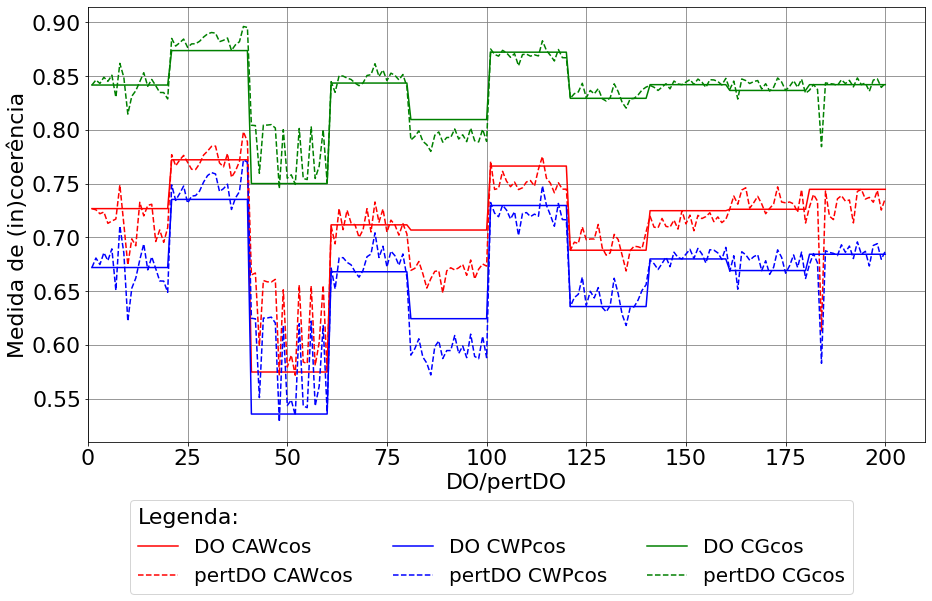

In [150]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

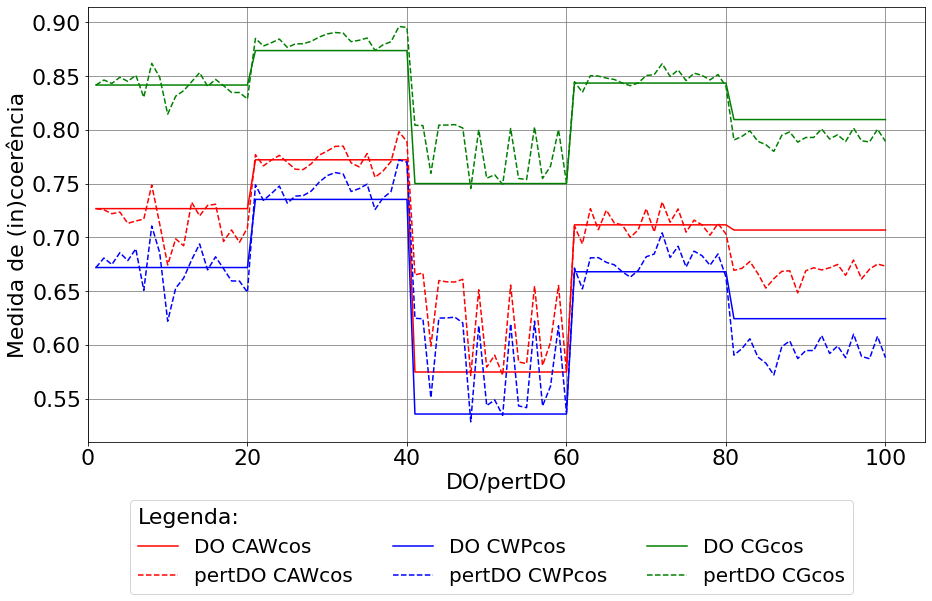

In [151]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

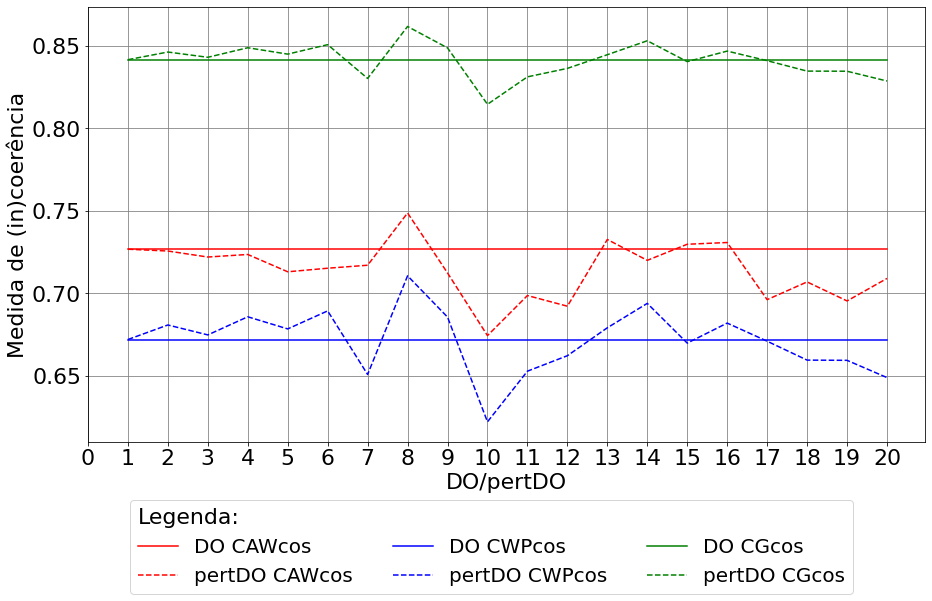

In [152]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

In [153]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

In [154]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

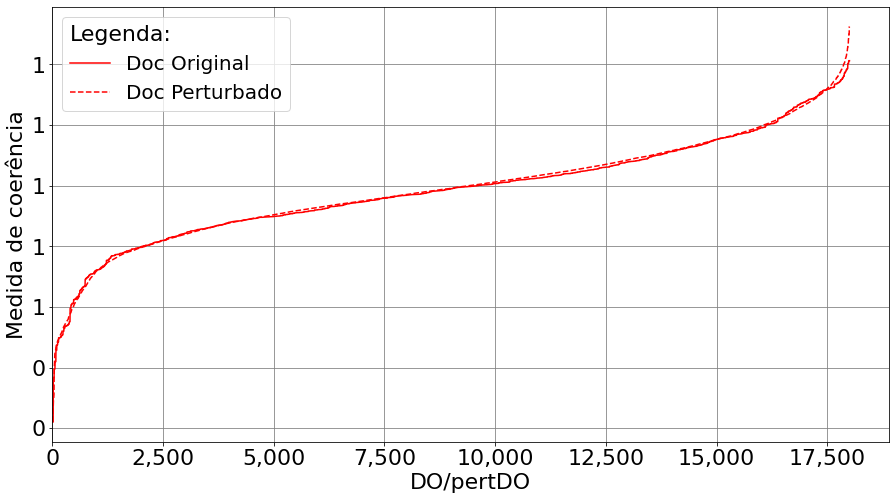

In [155]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

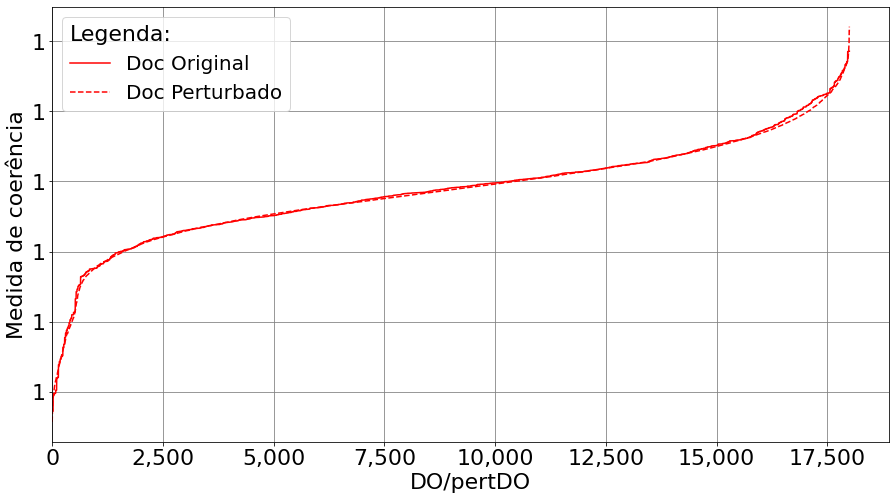

In [156]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

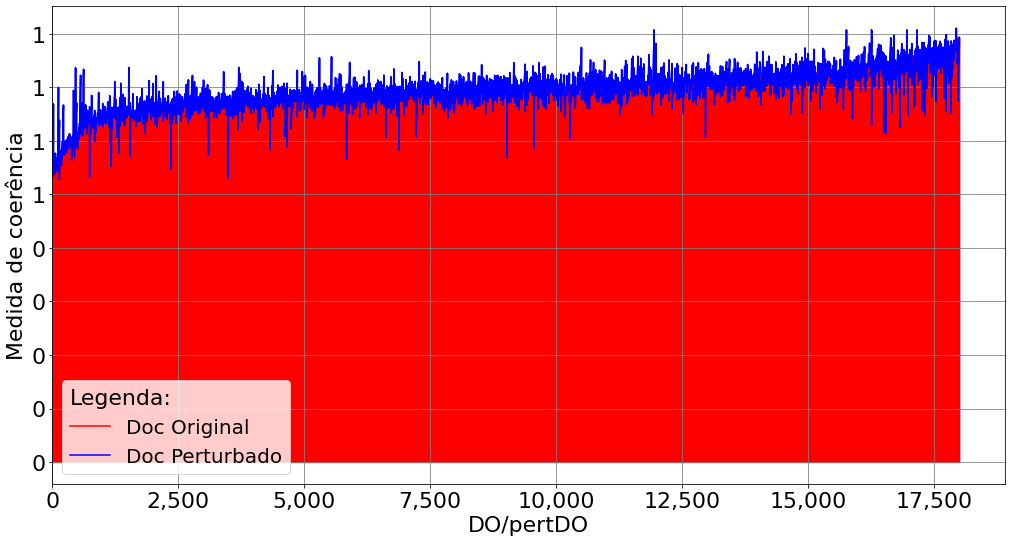

In [157]:
graficoLinhaMedida2Preenchido('Medida de coerência', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [158]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 218.05043870364415

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['020d7d9645494a83ad5eda59f16f9157', 0.04674809087406506, 81, 'Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição dedicada ao incentivo da ciência e tecnologia?']
['5041b9c96203403baa3d38c2933ec660', 0.050233193238576224, 324, 'O que o acadêmico deve respeitar na hora de escolher as disciplinas que deseja cursar?']
['4908f7899dab4f7f94185e14463ac4b3', 0.052406820383938624, 653, 'Quem será responsável por alterar a nota do aluno no Siscad?']
['fe050a7c0ff4410aa43a1b656a70f58f', 0.05362923521744578, 83, 'Qual teoria investiga as questões relativas à possibilidade de realizar certos tipos de computação em determinados tipos de máquina?']
['6ad8ea15044147118087cddcb8563d

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [159]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 102.51752452525784

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['824a7cde3e8348ecbf050e5d582d464d', 0.00011319915453600338, 649, 'Por que é necessário que um professor tenha qualificações acadêmicas e pedagógicas?']
['ec2eabdba8b040079e78f00659aa2072', 0.00032464896931372333, 178, 'Por que a contagem do tempo cursado é feita a partir do ingresso do acadêmico na UFMS?']
['c6052966e07a400f878c8588f60eb65e', 0.00047531453045934757, 394, 'Para quem foi criado os programas de “consciencialização gerencial”?']
['d4f754fcb68e429eae54fae9f4b9ad27', 0.0005387465159097937, 486, 'Quem irá definir as atividades que deverão ser cumpridas durante o regime de exer

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [160]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [161]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1d27e2dc7a8e4014ae7e22f34b8fbd28
DO: Qual teorema levou a definição de conceitos como recursividade e cálculo lambda?
     DET NOUN VERB DET NOUN ADP NOUN ADP NOUN CCONJ NOUN ADJ PUNCT 
  1 - Qual teorema define a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> define(>CAWcos(pertDO)=0,5486906221)] - VERB/VERB-1-0
  2 - Qual teorema e a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> e(>CAWcos(pertDO)=0,5570625861)] - VERB/CCONJ-0-0
  3 - Qual teorema envolve a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> envolve(>CAWcos(pertDO)=0,5605806063)] - VERB/VERB-1-0
  4 - Qual teorema exatamente a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> exatamente(>CAWcos(pertDO)=0,5690211194)] - VERB/ADV-0-0
  5 - Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ? [levou(C

In [162]:
visualizaMedidasEquacoesCSV("35235f810fc84abb8dc36265b8537194",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 35235f810fc84abb8dc36265b8537194
DO: O termo informática é sinônimo de que em Portugal?
     DET NOUN ADJ AUX ADJ SCONJ SCONJ ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
35235f810fc84abb8dc36265b8537194_pert_0;O termo informática é sinônimo de que em Portugal ?;termo;NOUN;0,6048345168;0,6151598083;0,8083512306;termo;NOUN;0,6048345168;0,6151598083;0,8083512306;0,5305639505;1;1
35235f810fc84abb8dc36265b8537194_pert_1;O nome informática é sinônimo de que em Portugal ?;termo;NOUN;0,6048345168;0,6151598083;0,8083512306;nome;NOUN;0,6325386829;0,6279007024;0,8152372718;0,2242732346;0;1
35235f810fc84abb8dc36265b8537194_pert_2;O que informática é sinônimo de que em Portugal ?;termo;NOUN;0,6048345168;0,6151598083;0,8083512306;que;SCONJ;0,6544157929;0,6561524007;0,8305786312;0,0387278683;0;0
35235f810fc84abb8dc36265b8537194_pert_3;O a

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [163]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 115.53291417838537

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8150ec1777054fc8838a52c1f2223290', 0.0002791881561279297, 233, 'como o acadêmico solicita revisão de avaliação de disciplina?']
['0f2f727416a14b6d8abab36816e04f9f', 0.0002968403009268039, 511, 'Por quem é administrado o POP da RNP em Mato Grosso do Sul?']
['ba930d3c69b445fe95787bee95481a69', 0.000321682294209813, 12, 'O que acontece caso o acadêmico não renove a matrícula e estiver impedido de trancar?']
['095cce836d6f4b5286038a974bbd2bcd', 0.00033812224864959717, 599, 'Quem inventou os logarítmos?']
['e71b21864cbc4e6fbc5c1925d5733c51', 0.0003455529610316699, 313, 'Para onde é enviado 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [164]:
id_documento = "b6cd60a93a0e47b387289b8c2accaa27"
id_documento = lista[0:1][0][0]

In [165]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8150ec1777054fc8838a52c1f2223290
DO: como o acadêmico solicita revisão de avaliação de disciplina?
     ADP DET NOUN VERB NOUN ADP NOUN ADP NOUN PUNCT 
  1 - como o acadêmico recebe revisão de avaliação de disciplina ? [solicita(>CAWcos(DO)=0,6743542287) -> recebe(CAWcos(pertDO)=0,6740750406)] - VERB/VERB-1-0
  2 - como o acadêmico obtém revisão de avaliação de disciplina ? [solicita(CAWcos(DO)=0,6743542287) -> obtém(>CAWcos(pertDO)=0,6772004366)] - VERB/VERB-1-0
  3 - como o acadêmico fará revisão de avaliação de disciplina ? [solicita(CAWcos(DO)=0,6743542287) -> fará(>CAWcos(pertDO)=0,6803099513)] - VERB/VERB-1-0
  4 - como o acadêmico tem revisão de avaliação de disciplina ? [solicita(CAWcos(DO)=0,6743542287) -> tem(>CAWcos(pertDO)=0,6811082363)] - VERB/VERB-1-0
  5 - como o acadêmico faria revisão de avaliação de disciplina ? [solicita(CAWcos(DO)=0,6743542287) -> faria(>CAWcos(pertDO)=0,6841524839)] - VERB/VERB-1-0
  6 - como o acadêmico realizou revisão de avaliação de disc

In [166]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 8150ec1777054fc8838a52c1f2223290
DO: como o acadêmico solicita revisão de avaliação de disciplina?
     ADP DET NOUN VERB NOUN ADP NOUN ADP NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
8150ec1777054fc8838a52c1f2223290_pert_0;como o acadêmico faz revisão de avaliação de disciplina ?;solicita;VERB;0,6743542287;0,6461146315;0,8238741815;faz;VERB;0,6866076456;0,6688614488;0,8378117025;0,4404912591;0;1
8150ec1777054fc8838a52c1f2223290_pert_1;como o acadêmico realiza revisão de avaliação de disciplina ?;solicita;VERB;0,6743542287;0,6461146315;0,8238741815;realiza;VERB;0,6860712634;0,6588940356;0,8324322402;0,2053969502;0;1
8150ec1777054fc8838a52c1f2223290_pert_2;como o acadêmico fará revisão de avaliação de disciplina ?;solicita;VERB;0,6743542287;0,6461146315;0,8238741815;fará;VERB;0,6803099513;0,6551691347;0,8304028332;0,0658005551;0;

#### Usando CWP

In [167]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 214.657381302004

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['020d7d9645494a83ad5eda59f16f9157', 0.03636504291545728, 33, 'Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição dedicada ao incentivo da ciência e tecnologia?']
['ba3433a97a9345b0bd1b93acd868eace', 0.039953920750590344, 20, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['a483f5977b9e4492add28bb1b6ec9b85', 0.04670338918854933, 22, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['c82bc430ce024bb7819ba16fa82ab1f6', 0.0496881710014481

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [168]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 114.13187446713658

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['bd1eed09be974557ad39a40f126818eb', 1.9499502683983927e-05, 256, 'O que é necessário para que um indivíduo se qualifique para obter a habilitação de professor nos países europeus?']
['d98b81dafbcf4dbe87e6bce09890667f', 0.0002719461917877197, 609, 'Qual a carga horária em hora-aula para disciplinas dispensadas?']
['339cd86a2ba04cdfb6f155f1801e6192', 0.00041003443978049336, 430, 'Por que grande parte dos eletroeletrônicos são sistemas de computação?']
['e009ce4de3054b4bb10aaa8b83b3a316', 0.0005526705221695627, 697, 'Onde são definidos os prazos para elaboração dos horários das aulas?']

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [169]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [170]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é depressão ? [monografia(CWPcos(DO)=0,6894744605) -> depressão(>CWPcos(pertDO)=0,7059518337)] - NOUN/NOUN-1-0
  2 - O que é democracia ? [monografia(CWPcos(DO)=0,6894744605) -> democracia(>CWPcos(pertDO)=0,7118581355)] - NOUN/NOUN-1-0
  3 - O que é cidadania ? [monografia(CWPcos(DO)=0,6894744605) -> cidadania(>CWPcos(pertDO)=0,7147664785)] - NOUN/VERB-0-0
  4 - O que é felicidade ? [monografia(CWPcos(DO)=0,6894744605) -> felicidade(>CWPcos(pertDO)=0,7174548388)] - NOUN/NOUN-1-0
  5 - O que é fé ? [monografia(CWPcos(DO)=0,6894744605) -> fé(>CWPcos(pertDO)=0,7210596323)] - NOUN/NOUN-1-0
  6 - O que é amor ? [monografia(CWPcos(DO)=0,6894744605) -> amor(>CWPcos(pertDO)=0,7256001651)] - NOUN/NOUN-1-0
  7 - O que é saúde ? [monografia(CWPcos(DO)=0,6894744605) -> saúde(>CWPcos(pertDO)=0,7292922616)] - NOUN/NOUN-1-0
  8 - O que é doença ? [monografia(CWPcos(DO)=0,6894744605) -> doença(>C

In [171]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;0,7068757713;0,6894744605;0,8606667161;isso;PRON;0,8072289377;0,7745791972;0,9053477526;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;0,7068757713;0,6894744605;0,8606667161;isto;PRON;0,7691097111;0,7453336000;0,8923303246;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;0,7068757713;0,6894744605;0,8606667161;amor;NOUN;0,7419747412;0,7256001651;0,8834386110;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;0,7068757713;0,6894744605;0,8606667161;câncer;NOUN;0,7605500370;0,7388642669;0,8894300222;0,0109702488;0;1
ad0858f4e016

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [172]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 100.52550683486751

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['da534dfa075d4429912e374814eeeee1', 0.00012987852096557617, 393, 'Quando nasceram os computadores atuais?']
['ce96bf83cc5d4fe09b8b525b5d94a6ff', 0.00028622945149736623, 310, 'Por que é importante ressaltar os problemas que a tecnologia traz para as empresas?']
['443a83414845417985c946ee1ff2ca5f', 0.00034711084195548914, 479, 'O que a engenharia de software visa?']
['501d80597c4d4b65b8a5466c022c455b', 0.000380345185597708, 269, 'Quando a área de computação foi solidificada na UFMS?']
['49b0aec482c743c496e15bf42ecd19f8', 0.0005591496433082765, 17, 'O que a UFPE criou numa parceria com 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [173]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [174]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: da534dfa075d4429912e374814eeeee1
DO: Quando nasceram os computadores atuais?
     SCONJ VERB DET NOUN ADJ PUNCT 
  1 - Quando viriam os computadores atuais ? [nasceram(>CWPcos(DO)=0,6415903250) -> viriam(CWPcos(pertDO)=0,6414604465)] - VERB/VERB-1-0
  2 - Quando nasceram os computadores atuais ? [nasceram(>CWPcos(DO)=0,6415903250) -> nasceram(CWPcos(pertDO)=0,6415903250)] - VERB/VERB-1-1
  3 - Quando apareceram os computadores atuais ? [nasceram(CWPcos(DO)=0,6415903250) -> apareceram(>CWPcos(pertDO)=0,6447793086)] - VERB/VERB-1-0
  4 - Quando vieram os computadores atuais ? [nasceram(CWPcos(DO)=0,6415903250) -> vieram(>CWPcos(pertDO)=0,6473642151)] - VERB/VERB-1-0
  5 - Quando nasceu os computadores atuais ? [nasceram(CWPcos(DO)=0,6415903250) -> nasceu(>CWPcos(pertDO)=0,6475892782)] - VERB/VERB-1-0
  6 - Quando começaram os computadores atuais ? [nasceram(CWPcos(DO)=0,6415903250) -> começaram(>CWPcos(pertDO)=0,6554707011)] - VERB/VERB-1-0
  7 - Quando surgiu os computadores atua

In [175]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: da534dfa075d4429912e374814eeeee1
DO: Quando nasceram os computadores atuais?
     SCONJ VERB DET NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
da534dfa075d4429912e374814eeeee1_pert_0;Quando surgiram os computadores atuais ?;nasceram;VERB;0,6790261269;0,6415903250;0,8373977542;surgiram;VERB;0,7005629778;0,6640419602;0,8484961291;0,4036145210;0;1
da534dfa075d4429912e374814eeeee1_pert_1;Quando chegaram os computadores atuais ?;nasceram;VERB;0,6790261269;0,6415903250;0,8373977542;chegaram;VERB;0,7018816113;0,6638030966;0,8483497103;0,2846279144;0;1
da534dfa075d4429912e374814eeeee1_pert_2;Quando nasceram os computadores atuais ?;nasceram;VERB;0,6790261269;0,6415903250;0,8373977542;nasceram;VERB;0,6790261269;0,6415903250;0,8373977542;0,0567913242;1;1
da534dfa075d4429912e374814eeeee1_pert_3;Quando vieram os computadores atuais ?;nasc

#### Usando CG

In [176]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 117.06116699415021

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['020d7d9645494a83ad5eda59f16f9157', 0.023455624995024404, 29, 'Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição dedicada ao incentivo da ciência e tecnologia?']
['ba3433a97a9345b0bd1b93acd868eace', 0.025414184520119343, 17, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['c82bc430ce024bb7819ba16fa82ab1f6', 0.031236663460731395, 63, 'Quantos dias no mínimo os lançamentos do período letivo especial no Siscad devem anteceder a data de matrícula do período letivo regular subsequente?']
['d4c1625406744464879a6e1c63192c0b', 0.03269792596499088, 246, 'Do que os matemáticos precisavam para descobrir quais proble

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [177]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 64.83889857508842

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['e009ce4de3054b4bb10aaa8b83b3a316', 0.0002913375695546838, 652, 'Onde são definidos os prazos para elaboração dos horários das aulas?']
['fb1f61b069ec4e968d07495c15cbc191', 0.0004125105010138741, 615, 'Quais são os órgãos colegiados superiores da UFMS?']
['d98b81dafbcf4dbe87e6bce09890667f', 0.0005011439323425737, 554, 'Qual a carga horária em hora-aula para disciplinas dispensadas?']
['39b55469ac19414db4eaf98c9df2fdce', 0.000553034245967865, 708, 'Como os dispositivos da placa-mãe são conectados?']
['e8413a5836124c9f85fbeec8ac228621', 0.0007005731264749793, 875, 'Como a pesquisa empíric

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [178]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [179]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1d27e2dc7a8e4014ae7e22f34b8fbd28
DO: Qual teorema levou a definição de conceitos como recursividade e cálculo lambda?
     DET NOUN VERB DET NOUN ADP NOUN ADP NOUN CCONJ NOUN ADJ PUNCT 
  1 - Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ? [levou(CGcos(DO)=0,7274799324) -> seja(>CGcos(pertDO)=0,7377534715)] - VERB/AUX-0-0
  2 - Qual teorema exatamente a definição de conceitos como recursividade e cálculo lambda ? [levou(CGcos(DO)=0,7274799324) -> exatamente(>CGcos(pertDO)=0,7394729738)] - VERB/ADV-0-0
  3 - Qual teorema e a definição de conceitos como recursividade e cálculo lambda ? [levou(CGcos(DO)=0,7274799324) -> e(>CGcos(pertDO)=0,7399766915)] - VERB/CCONJ-0-0
  4 - Qual teorema sobre a definição de conceitos como recursividade e cálculo lambda ? [levou(CGcos(DO)=0,7274799324) -> sobre(>CGcos(pertDO)=0,7458015566)] - VERB/ADP-0-0
  5 - Qual teorema envolve a definição de conceitos como recursividade e cálculo lambda ? [levou(CGcos(DO)=0,7274

In [180]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1d27e2dc7a8e4014ae7e22f34b8fbd28
DO: Qual teorema levou a definição de conceitos como recursividade e cálculo lambda?
     DET NOUN VERB DET NOUN ADP NOUN ADP NOUN CCONJ NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_0;Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219;0,7274799324;ser;AUX;0,5937801724;0,5581495748;0,7615986925;0,2911286950;0;0
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_1;Qual teorema é a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219;0,7274799324;é;AUX;0,5911813217;0,5494932567;0,7559079092;0,2742349803;0;0
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_2;Qual teorema seria a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [181]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6c0caf48bf9944059a38a2583d49c8ff', 5.590170621871948e-05, 345, 'Por quem geralmente é prestado o estágio?']
['9f3db258b4f4402cb4f4dc104deafa7a', 5.689594480728921e-05, 749, 'O que o professor deve consignar ao acadêmico?']
['443a83414845417985c946ee1ff2ca5f', 0.00010328739881515503, 569, 'O que a engenharia de software visa?']
['b11d5b1f4a1c4f69b982320656943681', 0.00013952595846988824, 648, 'O que a integração tecnológica flexibilizou?']
['2643b11ce22d46c58508c81342c34979', 0.0001428657107882536, 397, 'Qual a condição para ocorrer a integralização curricular?']

Os 5 últimos DOs
id_DO

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [182]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [183]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6c0caf48bf9944059a38a2583d49c8ff
DO: Por quem geralmente é prestado o estágio?
     ADP PRON ADV AUX VERB DET NOUN PUNCT 
  1 - Por quem geralmente é necessário o estágio ? [prestado(>CGcos(DO)=0,8162387908) -> necessário(CGcos(pertDO)=0,8161828890)] - VERB/ADJ-0-0
  2 - Por quem geralmente é obrigatório o estágio ? [prestado(CGcos(DO)=0,8162387908) -> obrigatório(>CGcos(pertDO)=0,8204697222)] - VERB/ADJ-0-0
  3 - Por quem geralmente é concedido o estágio ? [prestado(CGcos(DO)=0,8162387908) -> concedido(>CGcos(pertDO)=0,8220791221)] - VERB/VERB-1-0
  4 - Por quem geralmente é iniciado o estágio ? [prestado(CGcos(DO)=0,8162387908) -> iniciado(>CGcos(pertDO)=0,8220813498)] - VERB/VERB-1-0
  5 - Por quem geralmente é pedido o estágio ? [prestado(CGcos(DO)=0,8162387908) -> pedido(>CGcos(pertDO)=0,8224067166)] - VERB/VERB-1-0
  6 - Por quem geralmente é pago o estágio ? [prestado(CGcos(DO)=0,8162387908) -> pago(>CGcos(pertDO)=0,8241684139)] - VERB/VERB-1-0
  7 - Por quem geralmente é

In [184]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6c0caf48bf9944059a38a2583d49c8ff
DO: Por quem geralmente é prestado o estágio?
     ADP PRON ADV AUX VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
6c0caf48bf9944059a38a2583d49c8ff_pert_0;Por quem geralmente é feito o estágio ?;prestado;VERB;0,6707417113;0,6244094287;0,8162387908;feito;VERB;0,6936105915;0,6483112701;0,8318613917;0,4437850714;0;1
6c0caf48bf9944059a38a2583d49c8ff_pert_1;Por quem geralmente é realizado o estágio ?;prestado;VERB;0,6707417113;0,6244094287;0,8162387908;realizado;VERB;0,6886690685;0,6445121276;0,8298860341;0,1583155394;0;1
6c0caf48bf9944059a38a2583d49c8ff_pert_2;Por quem geralmente é contratado o estágio ?;prestado;VERB;0,6707417113;0,6244094287;0,8162387908;contratado;VERB;0,6932451214;0,6508899140;0,8332689926;0,0490389094;0;1
6c0caf48bf9944059a38a2583d49c8ff_pert_3;Por quem geralmente é procur

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [185]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 52.22226841906192

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['fe050a7c0ff4410aa43a1b656a70f58f', 0.00613900234824738, 83, 'Qual teoria investiga as questões relativas à possibilidade de realizar certos tipos de computação em determinados tipos de máquina?']
['020d7d9645494a83ad5eda59f16f9157', 0.006269116293300292, 81, 'Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição dedicada ao incentivo da ciência e tecnologia?']
['03e7eea5c2a74534aaac4bb640193fe9', 0.006597419083118505, 229, 'Quem noticiou que o DF passou a ser um novo exemplo de como a sociedade deve valorizar a atividade científica?']
['bc649c8e94fd489b96bc6274af04ca6c', 0.0069325268268585205, 365, 'O que permite com

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [186]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['824a7cde3e8348ecbf050e5d582d464d', 0.00011319915453600338, 649, 'Por que é necessário que um professor tenha qualificações acadêmicas e pedagógicas?']
['ec2eabdba8b040079e78f00659aa2072', 0.00032464896931372333, 178, 'Por que a contagem do tempo cursado é feita a partir do ingresso do acadêmico na UFMS?']
['c6052966e07a400f878c8588f60eb65e', 0.00047531453045934757, 394, 'Para quem foi criado os programas de “consciencialização gerencial”?']
['d4f754fcb68e429eae54fae9f4b9ad27', 0.0005387465159097937, 486, 'Quem irá definir as atividades que deverão ser cumpridas durante o regime de exercícios domi

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [187]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [188]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: deaad70fb20a415cb82109bdf64c9768
DO: O que o Siscad controla, acompanha e divulga?
     PRON PRON DET PROPN VERB PUNCT VERB CCONJ VERB PUNCT 
  1 - O que o Siscad controla , decide e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> decide(CAWcos(pertDO)=0,5435096762)] - VERB/VERB-1-0
  2 - O que o Siscad controla , julga e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> julga(CAWcos(pertDO)=0,5450604790)] - VERB/VERB-1-0
  3 - O que o Siscad controla , monitora e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> monitora(CAWcos(pertDO)=0,5508500983)] - VERB/ADJ-0-0
  4 - O que o Siscad controla , registra e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> registra(CAWcos(pertDO)=0,5538890668)] - VERB/VERB-1-0
  5 - O que o Siscad controla , publica e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> publica(CAWcos(pertDO)=0,5554332957)] - VERB/VERB-1-0
  6 - O que o Siscad controla , protege e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> protege(CAWcos(pertDO)=0,5558991

In [189]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: deaad70fb20a415cb82109bdf64c9768
DO: O que o Siscad controla, acompanha e divulga?
     PRON PRON DET PROPN VERB PUNCT VERB CCONJ VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
deaad70fb20a415cb82109bdf64c9768_pert_0;O que o Siscad controla , monitora e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;monitora;ADJ;0,5508500983;0,5637473269;0,7740980625;0,2842993736;0;0
deaad70fb20a415cb82109bdf64c9768_pert_1;O que o Siscad controla , avalia e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;avalia;VERB;0,5582145941;0,5725674434;0,7791956872;0,0741659030;0;1
deaad70fb20a415cb82109bdf64c9768_pert_2;O que o Siscad controla , controla e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;controla;VERB;0,7000167105;0,7065822429;0,8542798281;0,0611399487;0;1
deaad70fb20a415cb82109bdf64c9768_pert_

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [190]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8150ec1777054fc8838a52c1f2223290', 0.0002791881561279297, 233, 'como o acadêmico solicita revisão de avaliação de disciplina?']
['dbc27c80bdf8447ea1ef546dc162a168', 0.0002817263205846521, 147, 'Quem aprovou a criação do Doutorado em Ciência da Computação da UFMS?']
['0f2f727416a14b6d8abab36816e04f9f', 0.0002968403009268039, 511, 'Por quem é administrado o POP da RNP em Mato Grosso do Sul?']
['ba930d3c69b445fe95787bee95481a69', 0.000321682294209813, 12, 'O que acontece caso o acadêmico não renove a matrícula e estiver impedido de trancar?']
['095cce836d6f4b5286038a974bbd2bcd', 0.000338122248649597

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [191]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [192]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
  1 - Quais informações Podem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> Podem(CAWcos(pertDO)=0,5293493602)] - VERB/VERB-1-0
  2 - Quais informações permitem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> permitem(CAWcos(pertDO)=0,5297843450)] - VERB/VERB-1-0
  3 - Quais informações necessitam ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> necessitam(CAWcos(pertDO)=0,5384073671)] - VERB/VERB-1-0
  4 - Quais informações conseguem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> conseguem(CAWcos(pertDO)=0,5441259858)] - VERB/VERB-1-0
  5 - Quais informações querem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> querem(CAWcos(pertDO)=0,5491635485)] - VERB/VERB-1-0
  6 - Quais informações possam ser representad

In [193]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
b6cd60a93a0e47b387289b8c2accaa27_pert_0;Quais informações podem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;podem;VERB;0,6680364807;0,6661412001;0,8351032615;0,8817397952;1;1
b6cd60a93a0e47b387289b8c2accaa27_pert_1;Quais informações devem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;devem;VERB;0,5813690590;0,5765398502;0,7843103290;0,0939609706;0;1
b6cd60a93a0e47b387289b8c2accaa27_pert_2;Quais informações poderiam ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;poderiam;VERB;0,5658199307;0,5653810450;0,7777133226;0,0058162170;0;1


#### Usando CWP






In [194]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 52.22226841906192

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ba3433a97a9345b0bd1b93acd868eace', 0.00547475929845842, 20, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['a483f5977b9e4492add28bb1b6ec9b85', 0.005742503984554448, 22, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['d4c1625406744464879a6e1c63192c0b', 0.006529110709046937, 339, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['c82bc430ce024bb7

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [195]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['bd1eed09be974557ad39a40f126818eb', 1.9499502683983927e-05, 256, 'O que é necessário para que um indivíduo se qualifique para obter a habilitação de professor nos países europeus?']
['d98b81dafbcf4dbe87e6bce09890667f', 0.0002719461917877197, 609, 'Qual a carga horária em hora-aula para disciplinas dispensadas?']
['339cd86a2ba04cdfb6f155f1801e6192', 0.00041003443978049336, 430, 'Por que grande parte dos eletroeletrônicos são sistemas de computação?']
['e009ce4de3054b4bb10aaa8b83b3a316', 0.0005526705221695627, 697, 'Onde são definidos os prazos para elaboração dos horários das aulas?']
['0476289d1f2

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [196]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [197]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: deaad70fb20a415cb82109bdf64c9768
DO: O que o Siscad controla, acompanha e divulga?
     PRON PRON DET PROPN VERB PUNCT VERB CCONJ VERB PUNCT 
  1 - O que o Siscad controla , decide e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> decide(CAWcos(pertDO)=0,5435096762)] - VERB/VERB-1-0
  2 - O que o Siscad controla , julga e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> julga(CAWcos(pertDO)=0,5450604790)] - VERB/VERB-1-0
  3 - O que o Siscad controla , monitora e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> monitora(CAWcos(pertDO)=0,5508500983)] - VERB/ADJ-0-0
  4 - O que o Siscad controla , registra e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> registra(CAWcos(pertDO)=0,5538890668)] - VERB/VERB-1-0
  5 - O que o Siscad controla , publica e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> publica(CAWcos(pertDO)=0,5554332957)] - VERB/VERB-1-0
  6 - O que o Siscad controla , protege e divulga ? [acompanha(>CAWcos(DO)=0,5594089743) -> protege(CAWcos(pertDO)=0,5558991

In [198]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: deaad70fb20a415cb82109bdf64c9768
DO: O que o Siscad controla, acompanha e divulga?
     PRON PRON DET PROPN VERB PUNCT VERB CCONJ VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
deaad70fb20a415cb82109bdf64c9768_pert_0;O que o Siscad controla , monitora e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;monitora;ADJ;0,5508500983;0,5637473269;0,7740980625;0,2842993736;0;0
deaad70fb20a415cb82109bdf64c9768_pert_1;O que o Siscad controla , avalia e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;avalia;VERB;0,5582145941;0,5725674434;0,7791956872;0,0741659030;0;1
deaad70fb20a415cb82109bdf64c9768_pert_2;O que o Siscad controla , controla e divulga ?;acompanha;VERB;0,5594089743;0,5759379284;0,7813172579;controla;VERB;0,7000167105;0,7065822429;0,8542798281;0,0611399487;0;1
deaad70fb20a415cb82109bdf64c9768_pert_

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [199]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['da534dfa075d4429912e374814eeeee1', 0.00012987852096557617, 393, 'Quando nasceram os computadores atuais?']
['ce96bf83cc5d4fe09b8b525b5d94a6ff', 0.00028622945149736623, 310, 'Por que é importante ressaltar os problemas que a tecnologia traz para as empresas?']
['443a83414845417985c946ee1ff2ca5f', 0.00034711084195548914, 479, 'O que a engenharia de software visa?']
['501d80597c4d4b65b8a5466c022c455b', 0.000380345185597708, 269, 'Quando a área de computação foi solidificada na UFMS?']
['49c5dd3ba681417ab8d11af6d99faff3', 0.0005539606014887122, 302, 'Quantas horas diárias de estágio são garantidas pa

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [200]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [201]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
  1 - Quais informações Podem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> Podem(CAWcos(pertDO)=0,5293493602)] - VERB/VERB-1-0
  2 - Quais informações permitem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> permitem(CAWcos(pertDO)=0,5297843450)] - VERB/VERB-1-0
  3 - Quais informações necessitam ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> necessitam(CAWcos(pertDO)=0,5384073671)] - VERB/VERB-1-0
  4 - Quais informações conseguem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> conseguem(CAWcos(pertDO)=0,5441259858)] - VERB/VERB-1-0
  5 - Quais informações querem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> querem(CAWcos(pertDO)=0,5491635485)] - VERB/VERB-1-0
  6 - Quais informações possam ser representad

In [202]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
b6cd60a93a0e47b387289b8c2accaa27_pert_0;Quais informações podem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;podem;VERB;0,6680364807;0,6661412001;0,8351032615;0,8817397952;1;1
b6cd60a93a0e47b387289b8c2accaa27_pert_1;Quais informações devem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;devem;VERB;0,5813690590;0,5765398502;0,7843103290;0,0939609706;0;1
b6cd60a93a0e47b387289b8c2accaa27_pert_2;Quais informações poderiam ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;poderiam;VERB;0,5658199307;0,5653810450;0,7777133226;0,0058162170;0;1


#### Usando CG






In [203]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 52.22226841906192

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ba3433a97a9345b0bd1b93acd868eace', 0.0035016160262258955, 17, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['d4c1625406744464879a6e1c63192c0b', 0.003800216648313759, 246, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['a483f5977b9e4492add28bb1b6ec9b85', 0.004105089484034319, 18, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['1be21a9cc55a41a5

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [204]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['e009ce4de3054b4bb10aaa8b83b3a316', 0.0002913375695546838, 652, 'Onde são definidos os prazos para elaboração dos horários das aulas?']
['fb1f61b069ec4e968d07495c15cbc191', 0.0004125105010138741, 615, 'Quais são os órgãos colegiados superiores da UFMS?']
['ef5b758fd4fe44a38b538cb37f9abea9', 0.0004847139120102151, 273, 'O que deve haver para que um cálculo possa ser realizado por um algoritmo sendo executado em um computador?']
['d98b81dafbcf4dbe87e6bce09890667f', 0.0005011439323425737, 554, 'Qual a carga horária em hora-aula para disciplinas dispensadas?']
['369eec14595c4406800332c62cd3a035', 0.0005

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [205]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [206]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1d27e2dc7a8e4014ae7e22f34b8fbd28
DO: Qual teorema levou a definição de conceitos como recursividade e cálculo lambda?
     DET NOUN VERB DET NOUN ADP NOUN ADP NOUN CCONJ NOUN ADJ PUNCT 
  1 - Qual teorema define a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> define(>CAWcos(pertDO)=0,5486906221)] - VERB/VERB-1-0
  2 - Qual teorema e a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> e(>CAWcos(pertDO)=0,5570625861)] - VERB/CCONJ-0-0
  3 - Qual teorema envolve a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> envolve(>CAWcos(pertDO)=0,5605806063)] - VERB/VERB-1-0
  4 - Qual teorema exatamente a definição de conceitos como recursividade e cálculo lambda ? [levou(CAWcos(DO)=0,5359301368) -> exatamente(>CAWcos(pertDO)=0,5690211194)] - VERB/ADV-0-0
  5 - Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ? [levou(C

In [207]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1d27e2dc7a8e4014ae7e22f34b8fbd28
DO: Qual teorema levou a definição de conceitos como recursividade e cálculo lambda?
     DET NOUN VERB DET NOUN ADP NOUN ADP NOUN CCONJ NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_0;Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219;0,7274799324;ser;AUX;0,5937801724;0,5581495748;0,7615986925;0,2911286950;0;0
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_1;Qual teorema é a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219;0,7274799324;é;AUX;0,5911813217;0,5494932567;0,7559079092;0,2742349803;0;0
1d27e2dc7a8e4014ae7e22f34b8fbd28_pert_2;Qual teorema seria a definição de conceitos como recursividade e cálculo lambda ?;levou;VERB;0,5359301368;0,5048364219

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [208]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 52.22226841906192

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6c0caf48bf9944059a38a2583d49c8ff', 5.590170621871948e-05, 345, 'Por quem geralmente é prestado o estágio?']
['9f3db258b4f4402cb4f4dc104deafa7a', 5.689594480728921e-05, 749, 'O que o professor deve consignar ao acadêmico?']
['443a83414845417985c946ee1ff2ca5f', 0.00010328739881515503, 569, 'O que a engenharia de software visa?']
['b11d5b1f4a1c4f69b982320656943681', 0.00013952595846988824, 648, 'O que a integração tecnológica flexibilizou?']
['2643b11ce22d46c58508c81342c34979', 0.0001428657107882536, 397, 'Qual a condição para ocorrer a integralização curricular?']

Os 5 últimos DOs
id_DO, difabs, pos

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [209]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [210]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
  1 - Quais informações Podem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> Podem(CAWcos(pertDO)=0,5293493602)] - VERB/VERB-1-0
  2 - Quais informações permitem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> permitem(CAWcos(pertDO)=0,5297843450)] - VERB/VERB-1-0
  3 - Quais informações necessitam ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> necessitam(CAWcos(pertDO)=0,5384073671)] - VERB/VERB-1-0
  4 - Quais informações conseguem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> conseguem(CAWcos(pertDO)=0,5441259858)] - VERB/VERB-1-0
  5 - Quais informações querem ser representadas por uns e zeros ? [podem(>CAWcos(DO)=0,6680364807) -> querem(CAWcos(pertDO)=0,5491635485)] - VERB/VERB-1-0
  6 - Quais informações possam ser representad

In [211]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: b6cd60a93a0e47b387289b8c2accaa27
DO: Quais informações podem ser representadas por uns e zeros?
     DET NOUN VERB AUX VERB ADP PRON CCONJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
b6cd60a93a0e47b387289b8c2accaa27_pert_0;Quais informações podem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;podem;VERB;0,6680364807;0,6661412001;0,8351032615;0,8817397952;1;1
b6cd60a93a0e47b387289b8c2accaa27_pert_1;Quais informações devem ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;devem;VERB;0,5813690590;0,5765398502;0,7843103290;0,0939609706;0;1
b6cd60a93a0e47b387289b8c2accaa27_pert_2;Quais informações poderiam ser representadas por uns e zeros ?;podem;VERB;0,6680364807;0,6661412001;0,8351032615;poderiam;VERB;0,5658199307;0,5653810450;0,7777133226;0,0058162170;0;1


## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [212]:
medida = 'euc'

### Estatística

#### CAW

In [213]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 11382 de 18000
Percentual de documentos coerentes em relação ao total: 63.23333333333333
Acertos Perturbado : 6618 de 18000
Percentual de documentos incoerentes em relação ao total: 36.766666666666666


#### CWP

In [214]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10942 de 18000
Percentual de documentos coerentes em relação ao total: 60.78888888888889
Acertos Perturbado : 7058 de 18000
Percentual de documentos incoerentes em relação ao total: 39.211111111111116


#### CG

In [215]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10673 de 18000
Percentual de documentos coerentes em relação ao total: 59.29444444444445
Acertos Perturbado : 7327 de 18000
Percentual de documentos incoerentes em relação ao total: 40.705555555555556


### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





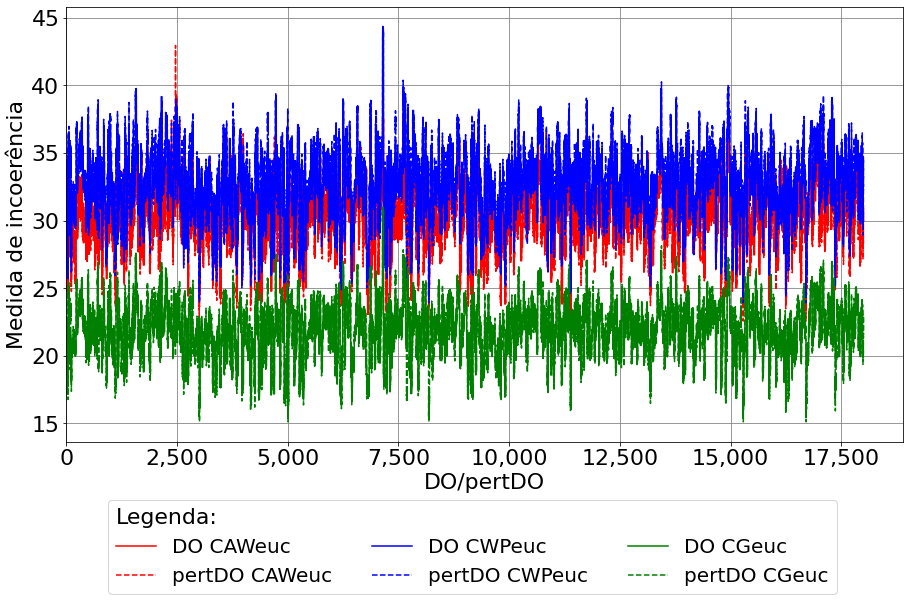

In [216]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [217]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 14820.05442970346
Diferença absoluta entre as medidas equação CWP : 14403.265076448042
Diferença absoluta entre as medidas equação CG  : 9398.204772475088


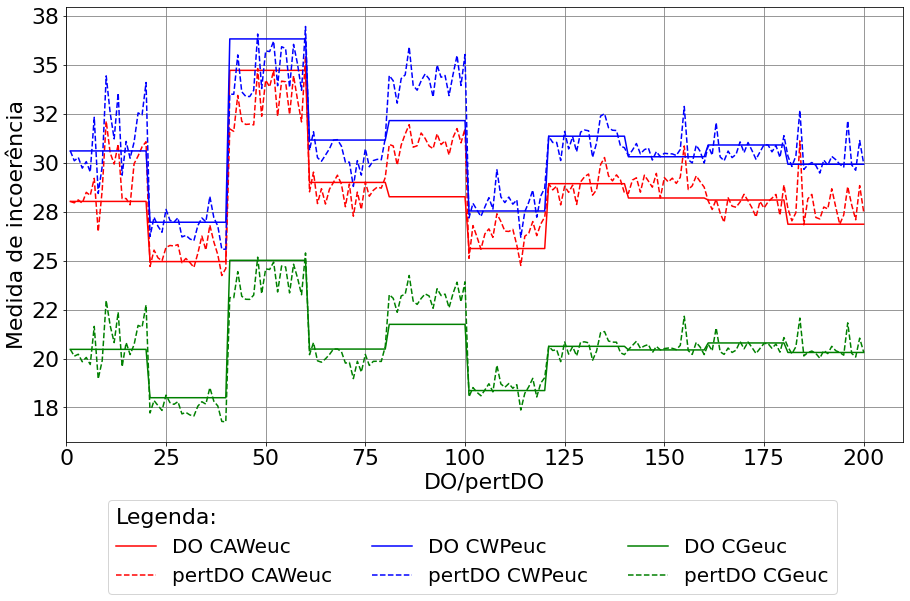

In [218]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

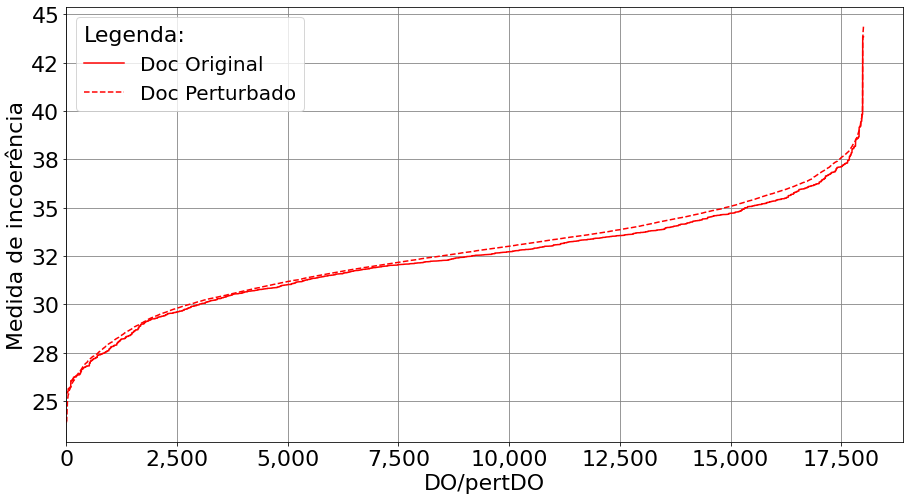

In [219]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

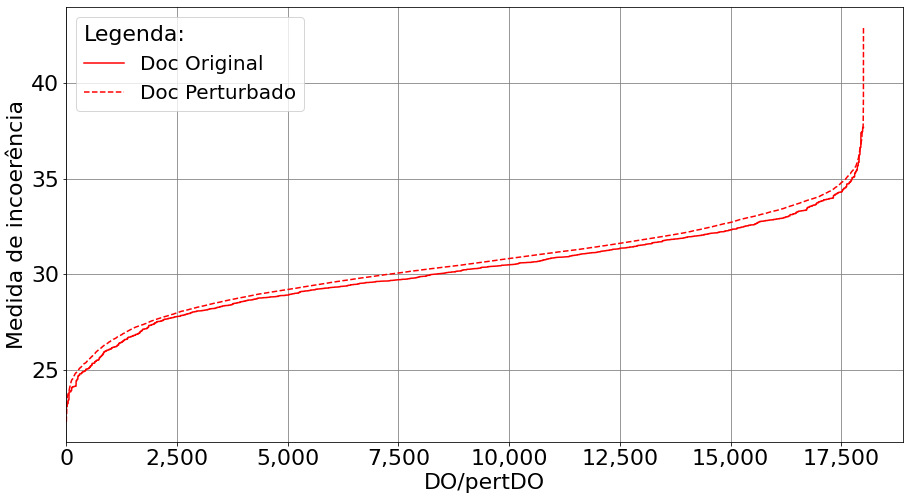

In [220]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

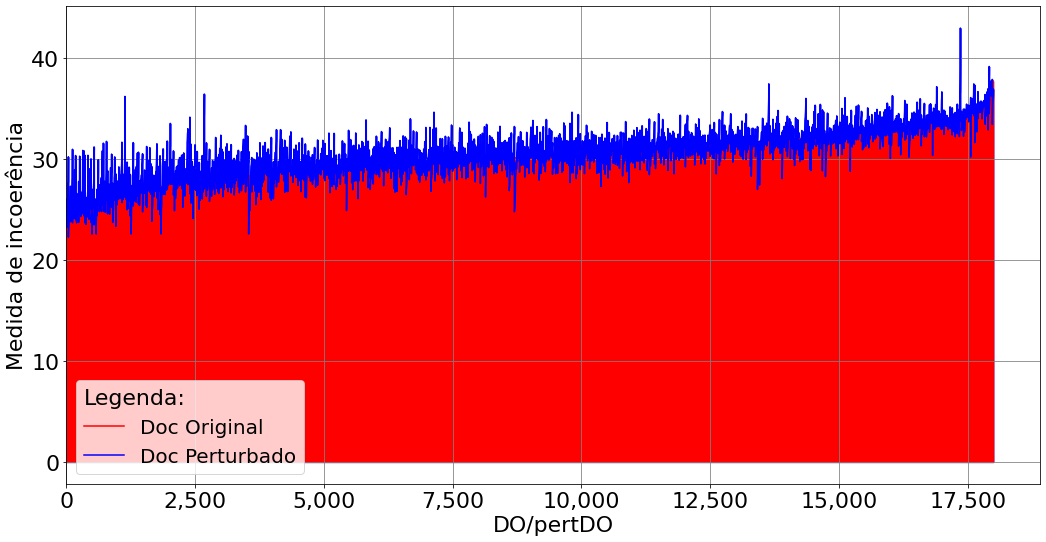

In [221]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

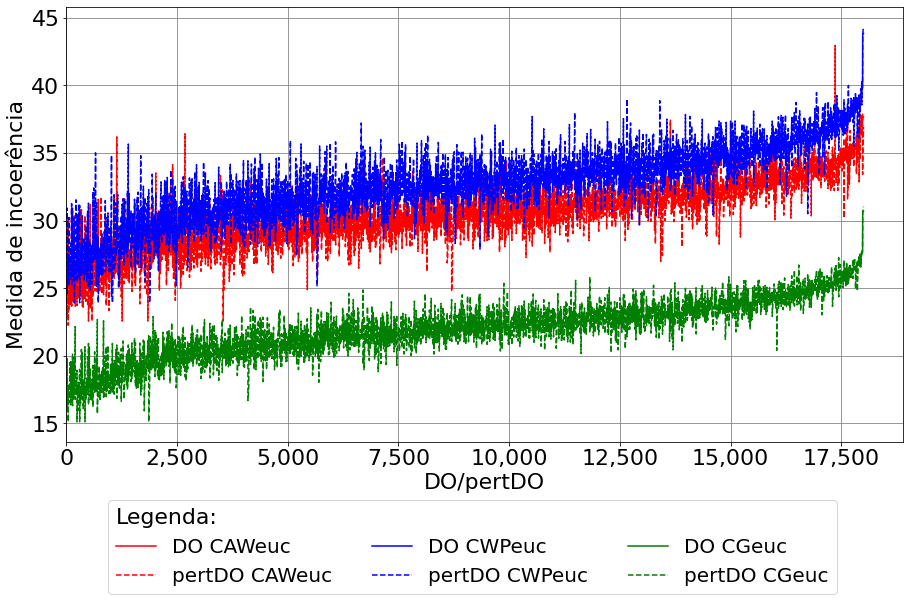

In [222]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [223]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 14820.05442970346
Diferença absoluta entre as medidas equação CWP : 14403.265076448042
Diferença absoluta entre as medidas equação CG  : 9398.204772475088


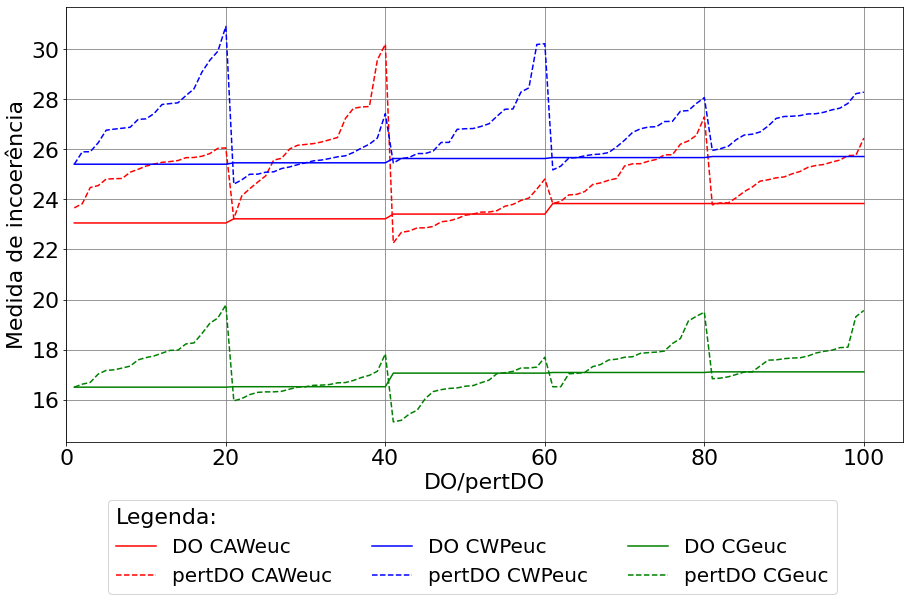

In [224]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

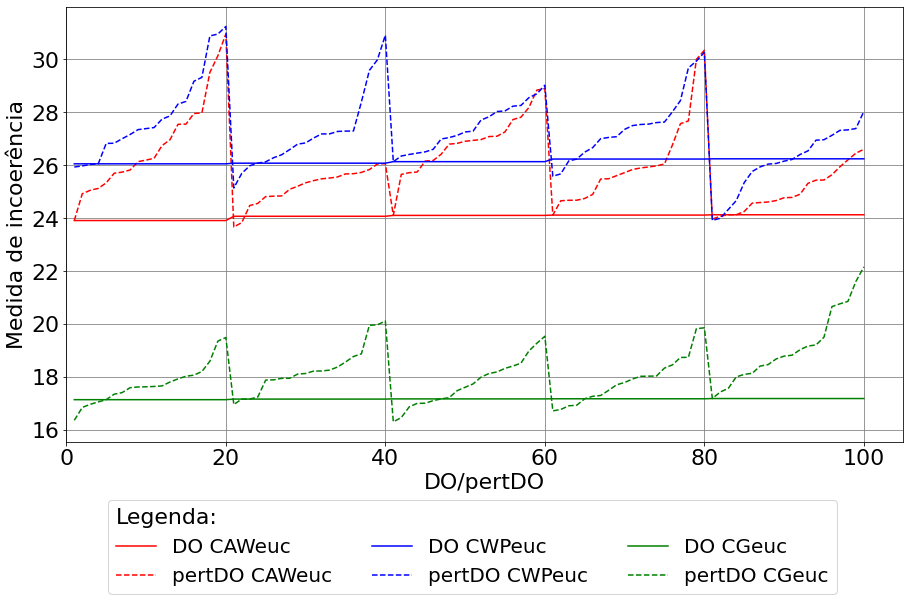

In [225]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[100:200], 
                   lista_perturbado_ordenado_CeucCAW[100:200], 
                   lista_original_ordenado_CeucCWP[100:200], 
                   lista_perturbado_ordenado_CeucCWP[100:200], 
                   lista_original_ordenado_CeucCG[100:200], 
                   lista_perturbado_ordenado_CeucCG[100:200],
                   medida = medida)

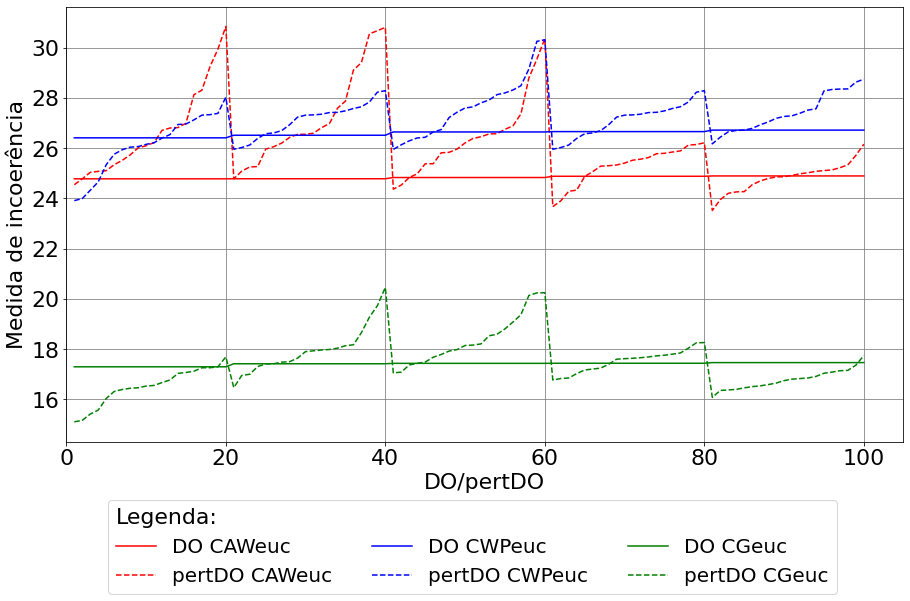

In [226]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

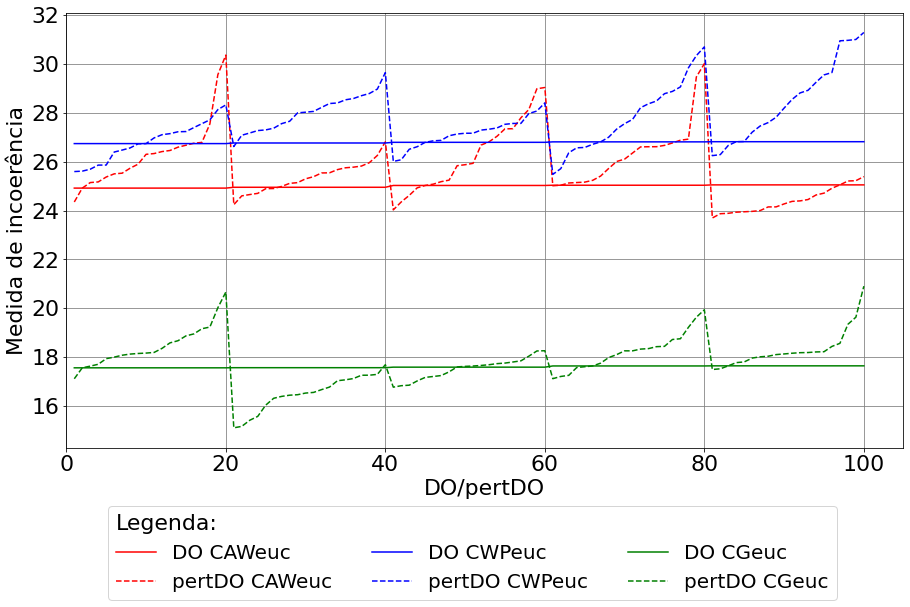

In [227]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[400:500], 
                   lista_perturbado_ordenado_CeucCAW[400:500], 
                   lista_original_ordenado_CeucCWP[400:500], 
                   lista_perturbado_ordenado_CeucCWP[400:500], 
                   lista_original_ordenado_CeucCG[400:500], 
                   lista_perturbado_ordenado_CeucCG[400:500],
                   medida = medida)

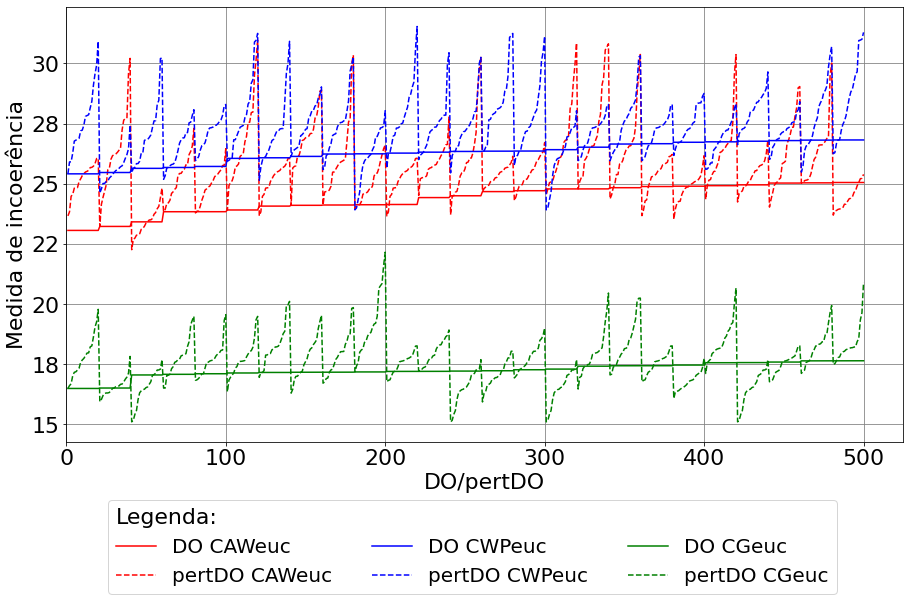

In [228]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:500], 
                   lista_perturbado_ordenado_CeucCAW[0:500], 
                   lista_original_ordenado_CeucCWP[0:500], 
                   lista_perturbado_ordenado_CeucCWP[0:500], 
                   lista_original_ordenado_CeucCG[0:500], 
                   lista_perturbado_ordenado_CeucCG[0:500],
                   medida = medida)

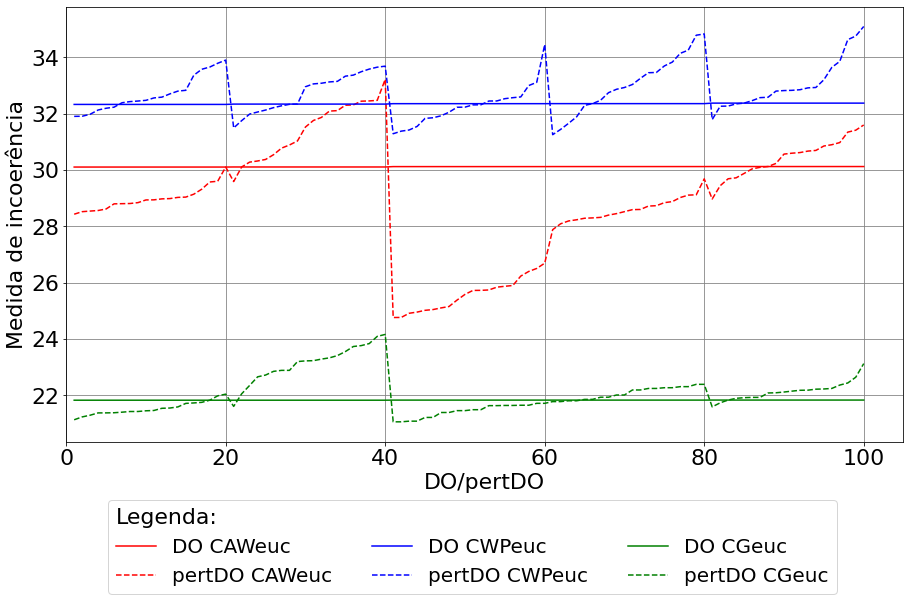

In [229]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[8660:8760], 
                   lista_perturbado_ordenado_CeucCAW[8660:8760], 
                   lista_original_ordenado_CeucCWP[8660:8760], 
                   lista_perturbado_ordenado_CeucCWP[8660:8760], 
                   lista_original_ordenado_CeucCG[8660:8760], 
                   lista_perturbado_ordenado_CeucCG[8660:8760],
                   medida = medida)

# DO central do gráfico com a maior diferença
# id = 83e3da1f287e4628b9b96ec37f549407
# difabs=91.10304737091059,
# Qual era o precursor do MEC?
# Posição gráfico 436 * 20 = 8720

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [230]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 14820.05442970346

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9148d87eb4b34d9390f8a485116361ae', 2.6836544672648124, 540, 'Por que o analista de sistemas deve traduzir a necessidade do usuário?']
['a483f5977b9e4492add28bb1b6ec9b85', 2.8269586563110494, 891, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['6165fa80922a40a6b14d8e7beba5fa8f', 3.2130204836527305, 649, 'Quais outros critérios para seleção dos canditados que os programas podem utilizar?']
['5def773266584a979d37f1dbafae4f0f', 3.6163371801376307, 459, 'Quais tipos de eventos científicos podem ser utilizados para integralização da carg

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [231]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 10188.14170953868

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['38087b76b3674f84bb471fdce0103265', 0.007447348700626577, 553, 'onde está definido o prazo para renovação de matrícula?']
['8526510cde3749f4802e483f09ae2411', 0.02004559834798414, 673, 'Como a ciência da computação se classifica enquanto ciência?']
['d0b4d7d5901643719e812aab15d70068', 0.03372987111409742, 344, 'Como os primeiros processadores eram construídos?']
['fd743cb55d85462f8981bd51fe92f50e', 0.052944183349609375, 140, 'quais são as atribuições acadêmicas do nde?']
['5a5ec083473f45e5ad2fb502fe70dae0', 0.0672165552775077, 131, 'O que foi concretizada com a divisão do estado de Mato 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [232]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [233]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: e1b3afdedeab46bc9dad7e7807935f06
DO: Do que se tratam as atividades complementares?
     ADP PRON PRON VERB DET NOUN ADJ PUNCT 
  1 - Do que se destacam as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> destacam(CAWeuc(pertDO)=28,9333485195)] - VERB/VERB-1-0
  2 - Do que se trata as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> trata(CAWeuc(pertDO)=29,9961817605)] - VERB/VERB-1-0
  3 - Do que se referem as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> referem(CAWeuc(pertDO)=30,0056329455)] - VERB/VERB-1-0
  4 - Do que se serve as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> serve(CAWeuc(pertDO)=31,4220564706)] - VERB/VERB-1-0
  5 - Do que se servem as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> servem(CAWeuc(pertDO)=31,5379358019)] - VERB/VERB-1-0
  6 - Do que se ocupam as atividades complementares ? [tratam(>CAWeuc(DO)=27,6948765346) -> ocupam(CAWeuc(pertDO)=31,6460143498)] - V

In [234]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: e1b3afdedeab46bc9dad7e7807935f06
DO: Do que se tratam as atividades complementares?
     ADP PRON PRON VERB DET NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
e1b3afdedeab46bc9dad7e7807935f06_pert_0;Do que se constituem as atividades complementares ?;tratam;VERB;27,6948765346;30,9044604983;20,5223143101;constituem;VERB;32,5598316193;34,1947631836;22,5744321346;0,4222203791;0;1
e1b3afdedeab46bc9dad7e7807935f06_pert_1;Do que se compõem as atividades complementares ?;tratam;VERB;27,6948765346;30,9044604983;20,5223143101;compõem;VERB;32,5420496804;33,9638396672;22,4283967018;0,2607199848;0;1
e1b3afdedeab46bc9dad7e7807935f06_pert_2;Do que se trata as atividades complementares ?;tratam;VERB;27,6948765346;30,9044604983;20,5223143101;trata;VERB;29,9961817605;32,5137908799;21,4960420132;0,0690004304;0;1
e1b3afdedeab46bc9dad7e7807935f06_

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [235]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 4631.912720164781

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['65520e827968404cb97a4f72182344d0', 0.0028009414672816035, 559, 'Quando haverá transmutação da espécie para a de vínculo empregatício?']
['1c25ffd9584c40b986d20e796359394a', 0.0028936598036040095, 453, 'Quando as universidades se tornaram bastante comuns nos EUA?']
['ea9b5bada6ce46b9ad8a0956cf0587ac', 0.006729841232299805, 235, 'Qual a finalidade da triagem em uma pesquisa?']
['98d89b0d12084b188e8d3be1cf804b82', 0.010762623378209213, 104, 'Quais alguns exemplos de atividades de extensão?']
['d880448a5a844d08a3a698c27558266a', 0.011840343475341797, 387, 'O que significa conhecer outras co

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [236]:
# id_documento = "83e3da1f287e4628b9b96ec37f549407"
id_documento = lista[-1:][0][0]

In [237]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
  1 - Qual era o projeto do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> projeto(>CAWeuc(pertDO)=24,7570171356)] - NOUN/NOUN-1-0
  2 - Qual era o planejamento do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> planejamento(>CAWeuc(pertDO)=24,7590586344)] - NOUN/NOUN-1-0
  3 - Qual era o discurso do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> discurso(>CAWeuc(pertDO)=24,9074808757)] - NOUN/NOUN-1-0
  4 - Qual era o plano do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> plano(>CAWeuc(pertDO)=24,9499314626)] - NOUN/NOUN-1-0
  5 - Qual era o programa do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> programa(>CAWeuc(pertDO)=25,0125392278)] - NOUN/NOUN-1-0
  6 - Qual era o problema do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> problema(>CAWeuc(pertDO)=25,0393320719)] - NOUN/NOUN-1-0
  7 - Qual era o objetivo do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> objetivo(>CAWeuc(per

In [238]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
83e3da1f287e4628b9b96ec37f549407_pert_0;Qual era o papel do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;papel;NOUN;25,1475639343;25,6950232188;17,0182169506;0,3289101720;0;1
83e3da1f287e4628b9b96ec37f549407_pert_1;Qual era o objetivo do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;objetivo;NOUN;25,0972169240;25,6952852522;17,0107917786;0,1418752521;0;1
83e3da1f287e4628b9b96ec37f549407_pert_2;Qual era o interesse do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;interesse;NOUN;25,7213439941;25,9434146881;17,1453673499;0,0540307462;0;1
83e3da1f287e4628b9b96ec37f549407_pert_3;Qual era o projeto do MEC ?;precursor;NOUN;30,1150817871;31,379189264

#### Usando CWP

In [239]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 14403.265076448042

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1be21a9cc55a41a5b3d98a094e4b3fbe', 3.0176888769799532, 848, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['d4c1625406744464879a6e1c63192c0b', 3.2323100582446926, 606, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['a483f5977b9e4492add28bb1b6ec9b85', 3.7080415619744826, 898, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['1a3a56a53b7846e4b8d0f736b3bd22fb', 3.7374381238257115, 781, 'Por que aspectos fundamentais do co

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [240]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 9260.707803141604

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d0b4d7d5901643719e812aab15d70068', 0.0115959530784977, 126, 'Como os primeiros processadores eram construídos?']
['f6e8d4a839274a6eb2c8ea1ebb310a49', 0.016671672011867145, 555, 'O que é necessário assegurar para se alcançar uma ciência forte?']
['e27536d0558f486692fbf13d1bfd9347', 0.03884833199636972, 121, 'Qual era o uso original do ábaco?']
['38087b76b3674f84bb471fdce0103265', 0.06349584791395557, 559, 'onde está definido o prazo para renovação de matrícula?']
['5a5ec083473f45e5ad2fb502fe70dae0', 0.08558385800092339, 631, 'O que foi concretizada com a divisão do estado de Mato Gros

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [241]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [242]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
  1 - O que a IBM ? [é(CWPeuc(DO)=28,3425981522) -> a(>CWPeuc(pertDO)=27,2870094299)] - AUX/DET-0-0
  2 - O que é IBM ? [é(>CWPeuc(DO)=28,3425981522) -> é(CWPeuc(pertDO)=28,3425981522)] - AUX/AUX-1-1
  3 - O que era IBM ? [é(>CWPeuc(DO)=28,3425981522) -> era(CWPeuc(pertDO)=28,4638517380)] - AUX/AUX-1-0
  4 - O que significa IBM ? [é(>CWPeuc(DO)=28,3425981522) -> significa(CWPeuc(pertDO)=28,8695428848)] - AUX/VERB-0-0
  5 - O que seria IBM ? [é(>CWPeuc(DO)=28,3425981522) -> seria(CWPeuc(pertDO)=29,6250007629)] - AUX/AUX-1-0
  6 - O que virou IBM ? [é(>CWPeuc(DO)=28,3425981522) -> virou(CWPeuc(pertDO)=29,7068653107)] - AUX/VERB-0-0
  7 - O que significava IBM ? [é(>CWPeuc(DO)=28,3425981522) -> significava(CWPeuc(pertDO)=30,3586475372)] - AUX/VERB-0-0
  8 - O que faz IBM ? [é(>CWPeuc(DO)=28,3425981522) -> faz(CWPeuc(pertDO)=30,3971769333)] - AUX/VERB-0-0
  9 - O que são IBM ? [é(>CWPeuc(DO)=28,3425981

In [243]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
939e08851c6c469da76d0c58d47e225c_pert_0;O que é IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;é;AUX;27,8640990257;28,3425981522;17,8714702606;0,7576153874;1;1
939e08851c6c469da76d0c58d47e225c_pert_1;O que significa IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;significa;VERB;28,0431160927;28,8695428848;18,2528549194;0,0786152855;0;0
939e08851c6c469da76d0c58d47e225c_pert_2;O que era IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;era;AUX;28,2613105774;28,4638517380;17,9476964951;0,0348249562;0;1
939e08851c6c469da76d0c58d47e225c_pert_3;O que a IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;a;DET;26,7453680038;27,2870094299;17,2529621124;0,0317151062;0;0
939e08851c6c469da76d0c58d47e225c_pert

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [244]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 5142.55727330647

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ec2eabdba8b040079e78f00659aa2072', 0.002669103784498361, 825, 'Por que a contagem do tempo cursado é feita a partir do ingresso do acadêmico na UFMS?']
['83bb139f5aa3458b998309aa2ef7ab41', 0.0029474667140405586, 84, 'Como a instituição presta serviço à comunidade?']
['1e34dcd126c74b61b70df158288cf73e', 0.005261898040771484, 72, 'O que os cientistas da computação estudam?']
['339cd86a2ba04cdfb6f155f1801e6192', 0.0085422515869098, 480, 'Por que grande parte dos eletroeletrônicos são sistemas de computação?']
['490b647d41cc4598b0c712a2bf48484e', 0.009015547923553413, 753, 'Quando o livro

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [245]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [246]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
  1 - Qual era o projeto do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> projeto(>CWPeuc(pertDO)=25,1716428484)] - NOUN/NOUN-1-0
  2 - Qual era o plano do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> plano(>CWPeuc(pertDO)=25,1851256234)] - NOUN/NOUN-1-0
  3 - Qual era o planejamento do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> planejamento(>CWPeuc(pertDO)=25,3109545935)] - NOUN/NOUN-1-0
  4 - Qual era o discurso do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> discurso(>CWPeuc(pertDO)=25,3262346359)] - NOUN/NOUN-1-0
  5 - Qual era o programa do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> programa(>CWPeuc(pertDO)=25,3981163388)] - NOUN/NOUN-1-0
  6 - Qual era o problema do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> problema(>CWPeuc(pertDO)=25,5556904929)] - NOUN/NOUN-1-0
  7 - Qual era o compromisso do MEC ? [precursor(CWPeuc(DO)=31,3791892642) -> compromisso(>CWPe

In [247]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
83e3da1f287e4628b9b96ec37f549407_pert_0;Qual era o papel do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;papel;NOUN;25,1475639343;25,6950232188;17,0182169506;0,3289101720;0;1
83e3da1f287e4628b9b96ec37f549407_pert_1;Qual era o objetivo do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;objetivo;NOUN;25,0972169240;25,6952852522;17,0107917786;0,1418752521;0;1
83e3da1f287e4628b9b96ec37f549407_pert_2;Qual era o interesse do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;interesse;NOUN;25,7213439941;25,9434146881;17,1453673499;0,0540307462;0;1
83e3da1f287e4628b9b96ec37f549407_pert_3;Qual era o projeto do MEC ?;precursor;NOUN;30,1150817871;31,379189264

#### Usando CG

In [248]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 9398.204772475088

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d4c1625406744464879a6e1c63192c0b', 2.1396274566650426, 678, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['a483f5977b9e4492add28bb1b6ec9b85', 2.1782159547548225, 899, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['1be21a9cc55a41a5b3d98a094e4b3fbe', 2.436682019914951, 844, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['1a3a56a53b7846e4b8d0f736b3bd22fb', 2.59779076827202, 813, 'Por que aspectos fundamentais do comporta

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [249]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 5830.254590460696

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['f6e8d4a839274a6eb2c8ea1ebb310a49', 0.012634754180911756, 563, 'O que é necessário assegurar para se alcançar uma ciência forte?']
['02a7283a040546ba8049e8898958bc28', 0.01707553863525746, 493, 'Ao que a ciência da computação contribuiu?']
['4d837be563594345b5ccb94612982dd0', 0.017553541395397332, 537, 'Onde o acadêmico pode solicitar aproveitamento dos estudos?']
['073f6a5ebc6e4416999320720d1e4f00', 0.03318818410237867, 561, 'O que o curso de Engenharia da Computação da UFRG visa?']
['7d0d7b4112a4413ebee5339414c75a8f', 0.059687508477104245, 343, 'Qual a principal atividade dos professo

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [250]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [251]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
  1 - O que a IBM ? [é(CGeuc(DO)=17,8714702606) -> a(>CGeuc(pertDO)=17,2529621124)] - AUX/DET-0-0
  2 - O que é IBM ? [é(>CGeuc(DO)=17,8714702606) -> é(CGeuc(pertDO)=17,8714702606)] - AUX/AUX-1-1
  3 - O que era IBM ? [é(>CGeuc(DO)=17,8714702606) -> era(CGeuc(pertDO)=17,9476964951)] - AUX/AUX-1-0
  4 - O que significa IBM ? [é(>CGeuc(DO)=17,8714702606) -> significa(CGeuc(pertDO)=18,2528549194)] - AUX/VERB-0-0
  5 - O que seria IBM ? [é(>CGeuc(DO)=17,8714702606) -> seria(CGeuc(pertDO)=18,6827550888)] - AUX/AUX-1-0
  6 - O que virou IBM ? [é(>CGeuc(DO)=17,8714702606) -> virou(CGeuc(pertDO)=18,8133628845)] - AUX/VERB-0-0
  7 - O que faz IBM ? [é(>CGeuc(DO)=17,8714702606) -> faz(CGeuc(pertDO)=19,2039617538)] - AUX/VERB-0-0
  8 - O que significava IBM ? [é(>CGeuc(DO)=17,8714702606) -> significava(CGeuc(pertDO)=19,2634336472)] - AUX/VERB-0-0
  9 - O que são IBM ? [é(>CGeuc(DO)=17,8714702606) -> são(CGeuc

In [252]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
939e08851c6c469da76d0c58d47e225c_pert_0;O que é IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;é;AUX;27,8640990257;28,3425981522;17,8714702606;0,7576153874;1;1
939e08851c6c469da76d0c58d47e225c_pert_1;O que significa IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;significa;VERB;28,0431160927;28,8695428848;18,2528549194;0,0786152855;0;0
939e08851c6c469da76d0c58d47e225c_pert_2;O que era IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;era;AUX;28,2613105774;28,4638517380;17,9476964951;0,0348249562;0;1
939e08851c6c469da76d0c58d47e225c_pert_3;O que a IBM ?;é;AUX;27,8640990257;28,3425981522;17,8714702606;a;DET;26,7453680038;27,2870094299;17,2529621124;0,0317151062;0;0
939e08851c6c469da76d0c58d47e225c_pert

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [253]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['69c6acf4d43e4af999464b87b3cf19e2', 0.0027159055074044147, 381, 'Qual a carga horária máxima dos cursos de aperfeiçoamento lato sensu?']
['d36826bb9cbb40b7a47074cff2c2c014', 0.005769252777099609, 558, 'Qual linguagem de programação é parecida com a linguagem de máquina?']
['13d4fe43c9504e05a5923b0ef30b9d18', 0.007241884867351445, 251, 'Qual o prazo de aprovação do plano de ensino das disciplinas?']
['98fd0355362742ff8fa7fb2c6570f843', 0.008650037977435687, 316, 'O que é uma universidade de múltiplos campi?']
['a522ca722b5046c498e41d97b36fe029', 0.011844928448020653, 495, 'Os estudos da

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [254]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [255]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
  1 - Qual era o projeto do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> projeto(>CGeuc(pertDO)=16,6881525857)] - NOUN/NOUN-1-0
  2 - Qual era o plano do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> plano(>CGeuc(pertDO)=16,6985555376)] - NOUN/NOUN-1-0
  3 - Qual era o planejamento do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> planejamento(>CGeuc(pertDO)=16,7655277252)] - NOUN/NOUN-1-0
  4 - Qual era o discurso do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> discurso(>CGeuc(pertDO)=16,7987267630)] - NOUN/NOUN-1-0
  5 - Qual era o programa do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> programa(>CGeuc(pertDO)=16,8472266878)] - NOUN/NOUN-1-0
  6 - Qual era o problema do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> problema(>CGeuc(pertDO)=16,9364245278)] - NOUN/NOUN-1-0
  7 - Qual era o objetivo do MEC ? [precursor(CGeuc(DO)=20,4400134768) -> objetivo(>CGeuc(pertDO)=17,010791

In [256]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
83e3da1f287e4628b9b96ec37f549407_pert_0;Qual era o papel do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;papel;NOUN;25,1475639343;25,6950232188;17,0182169506;0,3289101720;0;1
83e3da1f287e4628b9b96ec37f549407_pert_1;Qual era o objetivo do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;objetivo;NOUN;25,0972169240;25,6952852522;17,0107917786;0,1418752521;0;1
83e3da1f287e4628b9b96ec37f549407_pert_2;Qual era o interesse do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;interesse;NOUN;25,7213439941;25,9434146881;17,1453673499;0,0540307462;0;1
83e3da1f287e4628b9b96ec37f549407_pert_3;Qual era o projeto do MEC ?;precursor;NOUN;30,1150817871;31,379189264

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [257]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 3567.9501820143437

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9148d87eb4b34d9390f8a485116361ae', 0.2866050402323346, 540, 'Por que o analista de sistemas deve traduzir a necessidade do usuário?']
['6066b65076d145658e78b885fcf5496e', 0.3438364064918389, 898, 'De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?']
['d4c1625406744464879a6e1c63192c0b', 0.37118597591624436, 651, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos po

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [258]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['38087b76b3674f84bb471fdce0103265', 0.007447348700626577, 553, 'onde está definido o prazo para renovação de matrícula?']
['8526510cde3749f4802e483f09ae2411', 0.02004559834798414, 673, 'Como a ciência da computação se classifica enquanto ciência?']
['d0b4d7d5901643719e812aab15d70068', 0.03372987111409742, 344, 'Como os primeiros processadores eram construídos?']
['fd743cb55d85462f8981bd51fe92f50e', 0.052944183349609375, 140, 'quais são as atribuições acadêmicas do nde?']
['dbc27c80bdf8447ea1ef546dc162a168', 0.06247695287068922, 582, 'Quem aprovou a criação do Doutorado em Ciência da Computação da

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [259]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [260]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWeuc(DO)=26,2098102570) -> é(CAWeuc(pertDO)=26,2098102570)] - AUX/AUX-1-1
  2 - O que a USP ? [é(>CAWeuc(DO)=26,2098102570) -> a(CAWeuc(pertDO)=26,8321332932)] - AUX/DET-0-0
  3 - O que era USP ? [é(>CAWeuc(DO)=26,2098102570) -> era(CAWeuc(pertDO)=27,0399870872)] - AUX/AUX-1-0
  4 - O que uma USP ? [é(>CAWeuc(DO)=26,2098102570) -> uma(CAWeuc(pertDO)=27,5250420570)] - AUX/DET-0-0
  5 - O que faz USP ? [é(>CAWeuc(DO)=26,2098102570) -> faz(CAWeuc(pertDO)=27,7250576019)] - AUX/VERB-0-0
  6 - O que significa USP ? [é(>CAWeuc(DO)=26,2098102570) -> significa(CAWeuc(pertDO)=27,8147835732)] - AUX/VERB-0-0
  7 - O que virou USP ? [é(>CAWeuc(DO)=26,2098102570) -> virou(CAWeuc(pertDO)=27,9712409973)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWeuc(DO)=26,2098102570) -> define(CAWeuc(pertDO)=28,4284281731)] - AUX/VERB-0-0
  9 - O que seria USP ? [é(>CAWeuc(DO)=26,2098102570) -> seri

In [261]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;é;AUX;26,2098102570;27,2026498795;17,1819509506;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;era;AUX;27,0399870872;27,8034639359;17,5650926590;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;significa;VERB;27,8147835732;28,6617769241;18,1353904724;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;foi;AUX;31,2048654556;30,9250411987;19,5005043030;0,0172997192;0;1
3aa1c995b3ab491395042fee99790236_

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [262]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['65520e827968404cb97a4f72182344d0', 0.0028009414672816035, 559, 'Quando haverá transmutação da espécie para a de vínculo empregatício?']
['1c25ffd9584c40b986d20e796359394a', 0.0028936598036040095, 453, 'Quando as universidades se tornaram bastante comuns nos EUA?']
['ea9b5bada6ce46b9ad8a0956cf0587ac', 0.006729841232299805, 235, 'Qual a finalidade da triagem em uma pesquisa?']
['98d89b0d12084b188e8d3be1cf804b82', 0.010762623378209213, 104, 'Quais alguns exemplos de atividades de extensão?']
['d880448a5a844d08a3a698c27558266a', 0.011840343475341797, 387, 'O que significa conhecer outras coisas fora

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [263]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [264]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWeuc(DO)=28,3409357071) -> isso(>CAWeuc(pertDO)=22,5634469986)] - NOUN/PRON-0-0
  2 - O que é bom ? [monografia(CAWeuc(DO)=28,3409357071) -> bom(>CAWeuc(pertDO)=23,6070523262)] - NOUN/ADJ-0-0
  3 - O que é verdade ? [monografia(CAWeuc(DO)=28,3409357071) -> verdade(>CAWeuc(pertDO)=23,6604471207)] - NOUN/NOUN-1-0
  4 - O que é Deus ? [monografia(CAWeuc(DO)=28,3409357071) -> Deus(>CAWeuc(pertDO)=23,7533698082)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWeuc(DO)=28,3409357071) -> isto(>CAWeuc(pertDO)=24,4977254868)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWeuc(DO)=28,3409357071) -> melhor(>CAWeuc(pertDO)=24,5131220818)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWeuc(DO)=28,3409357071) -> ciência(>CAWeuc(pertDO)=25,0060806274)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWeuc(DO)=28,3409357071) -> música(>CAWeuc(pertDO)=

In [265]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;isso;PRON;22,5634469986;24,3264125824;15,4196424484;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;isto;PRON;24,4977254868;25,7617416382;16,3188808441;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;amor;NOUN;26,1760668755;26,9633476257;17,0373901367;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;câncer;NOUN;25,2308840752;26,2172393799;16,5588403702;0,010

#### Usando CWP






In [266]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 3567.9501820143437

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d4c1625406744464879a6e1c63192c0b', 0.3599097183327302, 606, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['1be21a9cc55a41a5b3d98a094e4b3fbe', 0.3889511024558985, 848, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['33ff5d874422412ba8d6f02ac6cb1fc1', 0.47592249783602725, 395, 'Quem foi o primeiro a explicar o sistema de numeração hindu-arábico?']
['d35a68e1e8344f38aee681eb5ba72c77', 0.4941757707034853, 793, 'O que os modelos usados pelos fundamentos científicos da engenharia de software devem permitir ao engenheiro?']
['7955d0a6cc9b4b8297a7ea

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [267]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d0b4d7d5901643719e812aab15d70068', 0.0115959530784977, 126, 'Como os primeiros processadores eram construídos?']
['f6e8d4a839274a6eb2c8ea1ebb310a49', 0.016671672011867145, 555, 'O que é necessário assegurar para se alcançar uma ciência forte?']
['e27536d0558f486692fbf13d1bfd9347', 0.03884833199636972, 121, 'Qual era o uso original do ábaco?']
['38087b76b3674f84bb471fdce0103265', 0.05153770446777628, 559, 'onde está definido o prazo para renovação de matrícula?']
['5a5ec083473f45e5ad2fb502fe70dae0', 0.08558385800092339, 631, 'O que foi concretizada com a divisão do estado de Mato Grosso?']

Os 5 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [268]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [269]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWeuc(DO)=26,2098102570) -> é(CAWeuc(pertDO)=26,2098102570)] - AUX/AUX-1-1
  2 - O que a USP ? [é(>CAWeuc(DO)=26,2098102570) -> a(CAWeuc(pertDO)=26,8321332932)] - AUX/DET-0-0
  3 - O que era USP ? [é(>CAWeuc(DO)=26,2098102570) -> era(CAWeuc(pertDO)=27,0399870872)] - AUX/AUX-1-0
  4 - O que uma USP ? [é(>CAWeuc(DO)=26,2098102570) -> uma(CAWeuc(pertDO)=27,5250420570)] - AUX/DET-0-0
  5 - O que faz USP ? [é(>CAWeuc(DO)=26,2098102570) -> faz(CAWeuc(pertDO)=27,7250576019)] - AUX/VERB-0-0
  6 - O que significa USP ? [é(>CAWeuc(DO)=26,2098102570) -> significa(CAWeuc(pertDO)=27,8147835732)] - AUX/VERB-0-0
  7 - O que virou USP ? [é(>CAWeuc(DO)=26,2098102570) -> virou(CAWeuc(pertDO)=27,9712409973)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWeuc(DO)=26,2098102570) -> define(CAWeuc(pertDO)=28,4284281731)] - AUX/VERB-0-0
  9 - O que seria USP ? [é(>CAWeuc(DO)=26,2098102570) -> seri

In [270]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;é;AUX;26,2098102570;27,2026498795;17,1819509506;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;era;AUX;27,0399870872;27,8034639359;17,5650926590;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;significa;VERB;27,8147835732;28,6617769241;18,1353904724;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;foi;AUX;31,2048654556;30,9250411987;19,5005043030;0,0172997192;0;1
3aa1c995b3ab491395042fee99790236_

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [271]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ec2eabdba8b040079e78f00659aa2072', 0.002669103784498361, 825, 'Por que a contagem do tempo cursado é feita a partir do ingresso do acadêmico na UFMS?']
['83bb139f5aa3458b998309aa2ef7ab41', 0.0029474667140405586, 84, 'Como a instituição presta serviço à comunidade?']
['1e34dcd126c74b61b70df158288cf73e', 0.005261898040771484, 72, 'O que os cientistas da computação estudam?']
['339cd86a2ba04cdfb6f155f1801e6192', 0.0085422515869098, 480, 'Por que grande parte dos eletroeletrônicos são sistemas de computação?']
['490b647d41cc4598b0c712a2bf48484e', 0.009015547923553413, 753, 'Quando o livro Calculando

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [272]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [273]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
  1 - Qual era o projeto do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> projeto(>CAWeuc(pertDO)=24,7570171356)] - NOUN/NOUN-1-0
  2 - Qual era o planejamento do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> planejamento(>CAWeuc(pertDO)=24,7590586344)] - NOUN/NOUN-1-0
  3 - Qual era o discurso do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> discurso(>CAWeuc(pertDO)=24,9074808757)] - NOUN/NOUN-1-0
  4 - Qual era o plano do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> plano(>CAWeuc(pertDO)=24,9499314626)] - NOUN/NOUN-1-0
  5 - Qual era o programa do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> programa(>CAWeuc(pertDO)=25,0125392278)] - NOUN/NOUN-1-0
  6 - Qual era o problema do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> problema(>CAWeuc(pertDO)=25,0393320719)] - NOUN/NOUN-1-0
  7 - Qual era o objetivo do MEC ? [precursor(CAWeuc(DO)=30,1150817871) -> objetivo(>CAWeuc(per

In [274]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
83e3da1f287e4628b9b96ec37f549407_pert_0;Qual era o papel do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;papel;NOUN;25,1475639343;25,6950232188;17,0182169506;0,3289101720;0;1
83e3da1f287e4628b9b96ec37f549407_pert_1;Qual era o objetivo do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;objetivo;NOUN;25,0972169240;25,6952852522;17,0107917786;0,1418752521;0;1
83e3da1f287e4628b9b96ec37f549407_pert_2;Qual era o interesse do MEC ?;precursor;NOUN;30,1150817871;31,3791892642;20,4400134768;interesse;NOUN;25,7213439941;25,9434146881;17,1453673499;0,0540307462;0;1
83e3da1f287e4628b9b96ec37f549407_pert_3;Qual era o projeto do MEC ?;precursor;NOUN;30,1150817871;31,379189264

#### Usando CG






In [275]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 3567.9501820143437

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d4c1625406744464879a6e1c63192c0b', 0.2347439659966426, 678, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['1be21a9cc55a41a5b3d98a094e4b3fbe', 0.2682883398873521, 844, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['7955d0a6cc9b4b8297a7ea52c8b2d0ea', 0.31845434088455704, 891, 'O trancamento de matrícula deve ser feito caso o regime de exercícios domicilares for superior a quantos semestres?']
['33ff5d874422412ba8d6f02ac6cb1fc1', 0.324559291203812, 553, 'Quem foi o primeiro a explicar o sistema de numeração hindu-arábico?']
['6066b65076d145658e7

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [276]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['f6e8d4a839274a6eb2c8ea1ebb310a49', 0.012634754180911756, 563, 'O que é necessário assegurar para se alcançar uma ciência forte?']
['02a7283a040546ba8049e8898958bc28', 0.01707553863525746, 493, 'Ao que a ciência da computação contribuiu?']
['4d837be563594345b5ccb94612982dd0', 0.017553541395397332, 537, 'Onde o acadêmico pode solicitar aproveitamento dos estudos?']
['073f6a5ebc6e4416999320720d1e4f00', 0.03318818410237867, 561, 'O que o curso de Engenharia da Computação da UFRG visa?']
['fd8de2206a504159ab3f3164798fefc2', 0.03737926483154297, 520, 'O Pergamum é acessível por quais computadores?']

Os

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [277]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [278]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWeuc(DO)=26,2098102570) -> é(CAWeuc(pertDO)=26,2098102570)] - AUX/AUX-1-1
  2 - O que a USP ? [é(>CAWeuc(DO)=26,2098102570) -> a(CAWeuc(pertDO)=26,8321332932)] - AUX/DET-0-0
  3 - O que era USP ? [é(>CAWeuc(DO)=26,2098102570) -> era(CAWeuc(pertDO)=27,0399870872)] - AUX/AUX-1-0
  4 - O que uma USP ? [é(>CAWeuc(DO)=26,2098102570) -> uma(CAWeuc(pertDO)=27,5250420570)] - AUX/DET-0-0
  5 - O que faz USP ? [é(>CAWeuc(DO)=26,2098102570) -> faz(CAWeuc(pertDO)=27,7250576019)] - AUX/VERB-0-0
  6 - O que significa USP ? [é(>CAWeuc(DO)=26,2098102570) -> significa(CAWeuc(pertDO)=27,8147835732)] - AUX/VERB-0-0
  7 - O que virou USP ? [é(>CAWeuc(DO)=26,2098102570) -> virou(CAWeuc(pertDO)=27,9712409973)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWeuc(DO)=26,2098102570) -> define(CAWeuc(pertDO)=28,4284281731)] - AUX/VERB-0-0
  9 - O que seria USP ? [é(>CAWeuc(DO)=26,2098102570) -> seri

In [279]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;é;AUX;26,2098102570;27,2026498795;17,1819509506;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;era;AUX;27,0399870872;27,8034639359;17,5650926590;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;significa;VERB;27,8147835732;28,6617769241;18,1353904724;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;26,2098102570;27,2026498795;17,1819509506;foi;AUX;31,2048654556;30,9250411987;19,5005043030;0,0172997192;0;1
3aa1c995b3ab491395042fee99790236_

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [280]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 3567.9501820143437

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['69c6acf4d43e4af999464b87b3cf19e2', 0.0027159055074044147, 381, 'Qual a carga horária máxima dos cursos de aperfeiçoamento lato sensu?']
['d36826bb9cbb40b7a47074cff2c2c014', 0.005769252777099609, 558, 'Qual linguagem de programação é parecida com a linguagem de máquina?']
['13d4fe43c9504e05a5923b0ef30b9d18', 0.007241884867351445, 251, 'Qual o prazo de aprovação do plano de ensino das disciplinas?']
['98fd0355362742ff8fa7fb2c6570f843', 0.008650037977435687, 316, 'O que é uma universidade de múltiplos campi?']
['a522ca722b5046c498e41d97b36fe029', 0.011844928448020653, 495, 'Os estudos da ciência da c

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [281]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [282]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWeuc(DO)=28,3409357071) -> isso(>CAWeuc(pertDO)=22,5634469986)] - NOUN/PRON-0-0
  2 - O que é bom ? [monografia(CAWeuc(DO)=28,3409357071) -> bom(>CAWeuc(pertDO)=23,6070523262)] - NOUN/ADJ-0-0
  3 - O que é verdade ? [monografia(CAWeuc(DO)=28,3409357071) -> verdade(>CAWeuc(pertDO)=23,6604471207)] - NOUN/NOUN-1-0
  4 - O que é Deus ? [monografia(CAWeuc(DO)=28,3409357071) -> Deus(>CAWeuc(pertDO)=23,7533698082)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWeuc(DO)=28,3409357071) -> isto(>CAWeuc(pertDO)=24,4977254868)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWeuc(DO)=28,3409357071) -> melhor(>CAWeuc(pertDO)=24,5131220818)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWeuc(DO)=28,3409357071) -> ciência(>CAWeuc(pertDO)=25,0060806274)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWeuc(DO)=28,3409357071) -> música(>CAWeuc(pertDO)=

In [283]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;isso;PRON;22,5634469986;24,3264125824;15,4196424484;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;isto;PRON;24,4977254868;25,7617416382;16,3188808441;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;amor;NOUN;26,1760668755;26,9633476257;17,0373901367;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;28,3409357071;29,1893957138;19,1533046722;câncer;NOUN;25,2308840752;26,2172393799;16,5588403702;0,010

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [284]:
medida = 'man'

### Estatística

#### CAW

In [285]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10988 de 18000
Percentual de documentos coerentes em relação ao total: 61.044444444444444
Acertos Perturbado : 7012 de 18000
Percentual de documentos incoerentes em relação ao total: 38.955555555555556


#### CWP

In [286]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10516 de 18000
Percentual de documentos coerentes em relação ao total: 58.42222222222222
Acertos Perturbado : 7484 de 18000
Percentual de documentos incoerentes em relação ao total: 41.57777777777778


#### CG

In [287]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 10282 de 18000
Percentual de documentos coerentes em relação ao total: 57.12222222222222
Acertos Perturbado : 7718 de 18000
Percentual de documentos incoerentes em relação ao total: 42.87777777777777


### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





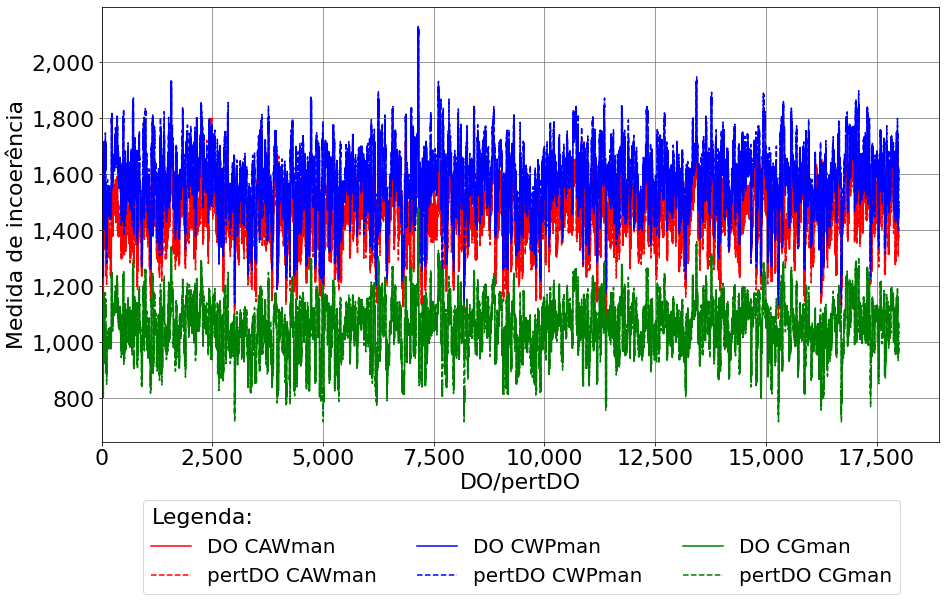

In [288]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [289]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 654370.5883527934
Diferença entre as equação CWP      : 640539.6611529754
Diferença entre as equação CG       : 420778.1671976788


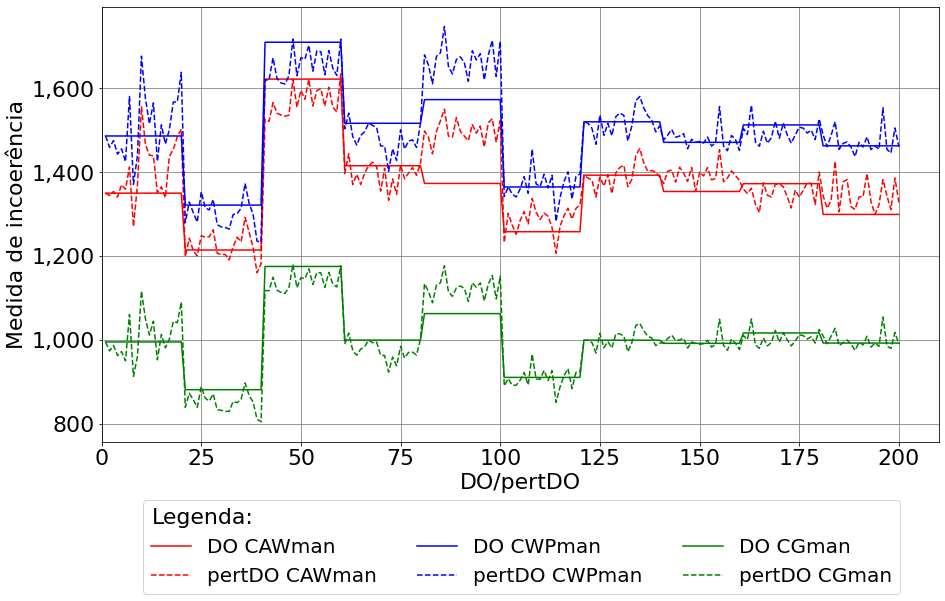

In [290]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

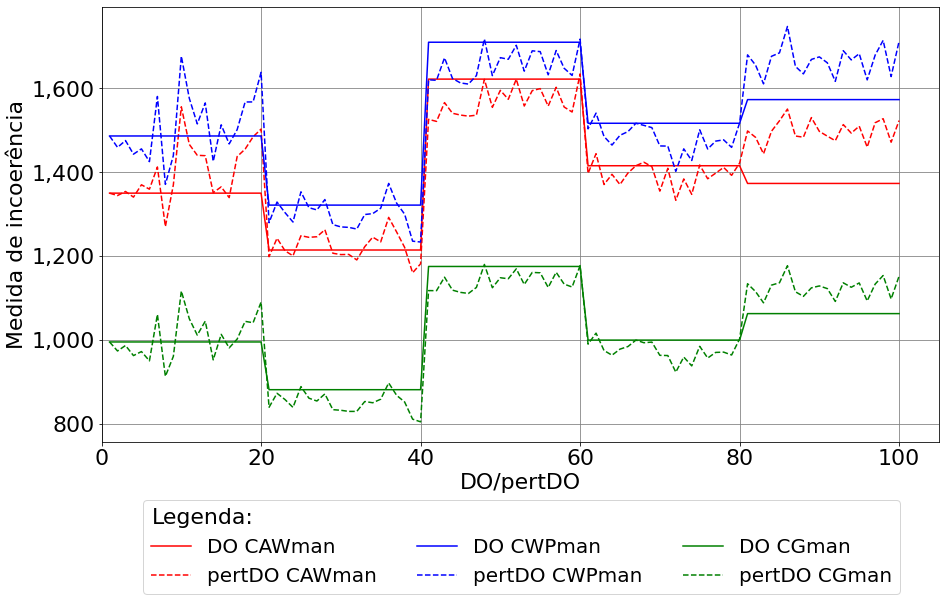

In [291]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

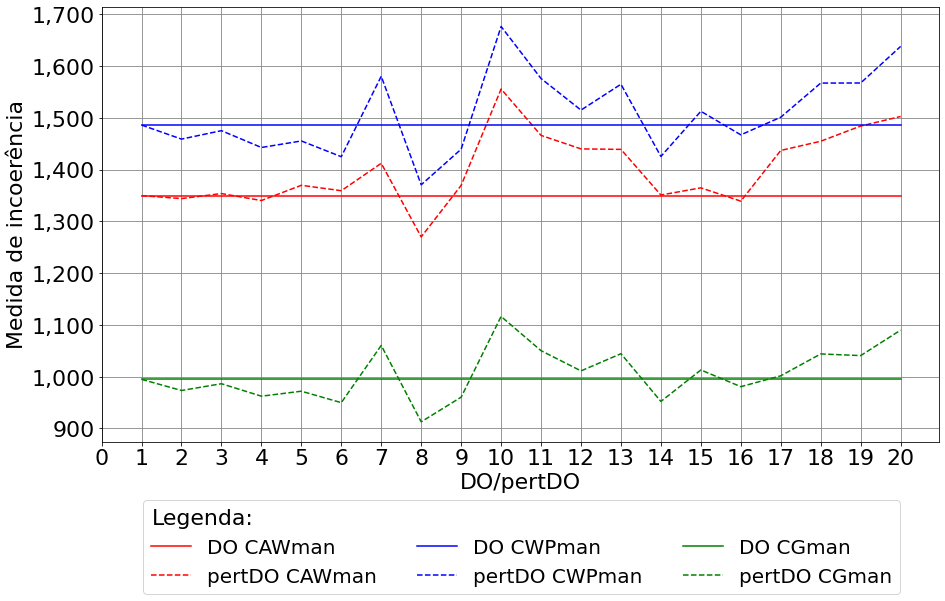

In [292]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

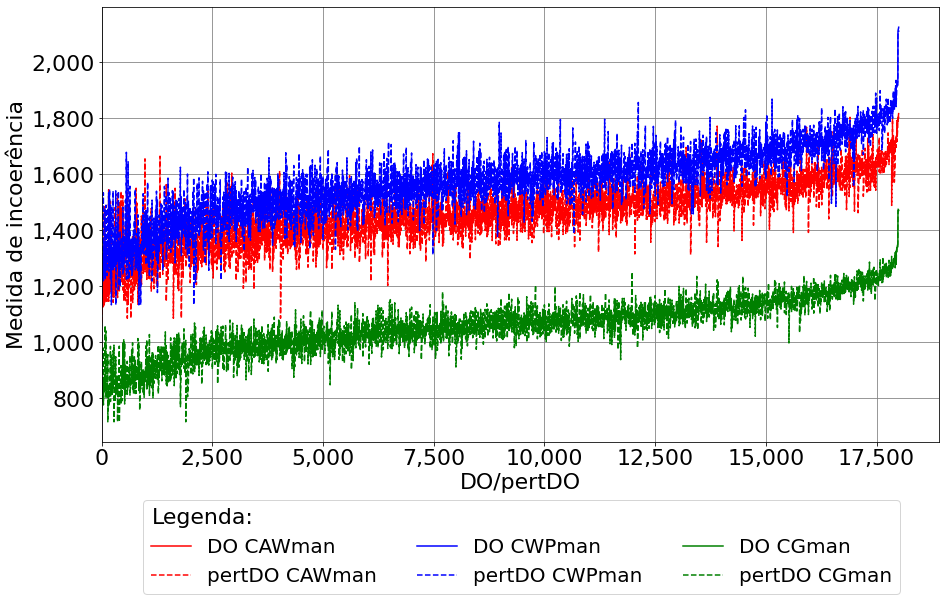

In [293]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

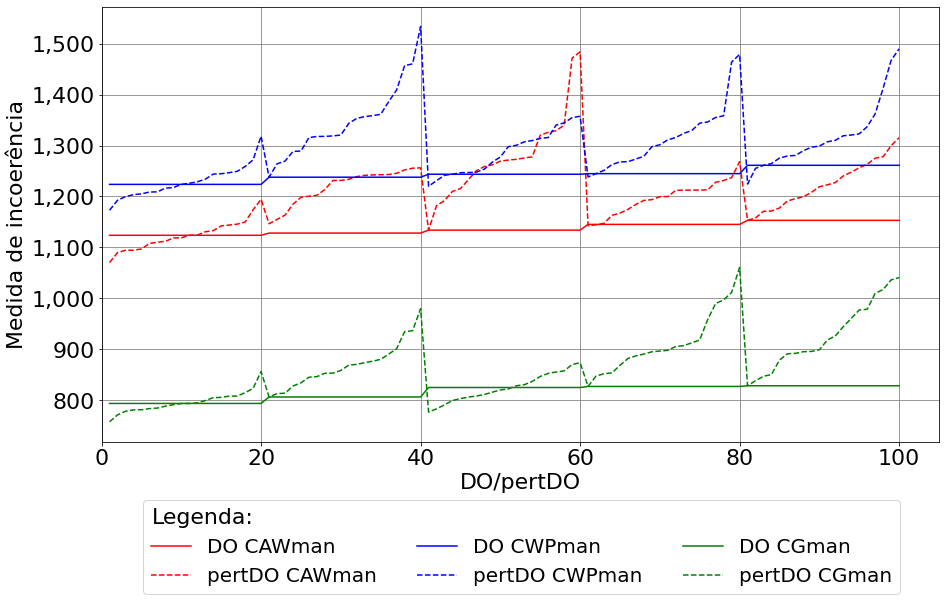

In [294]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

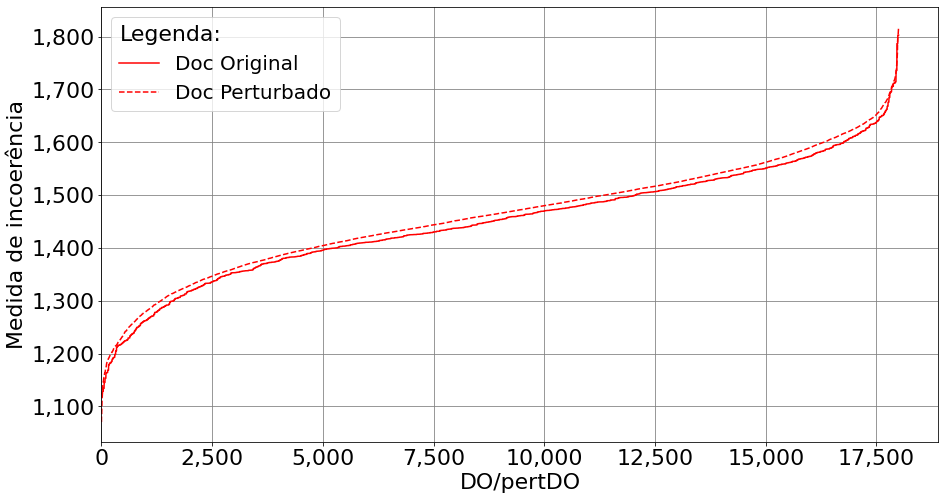

In [295]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

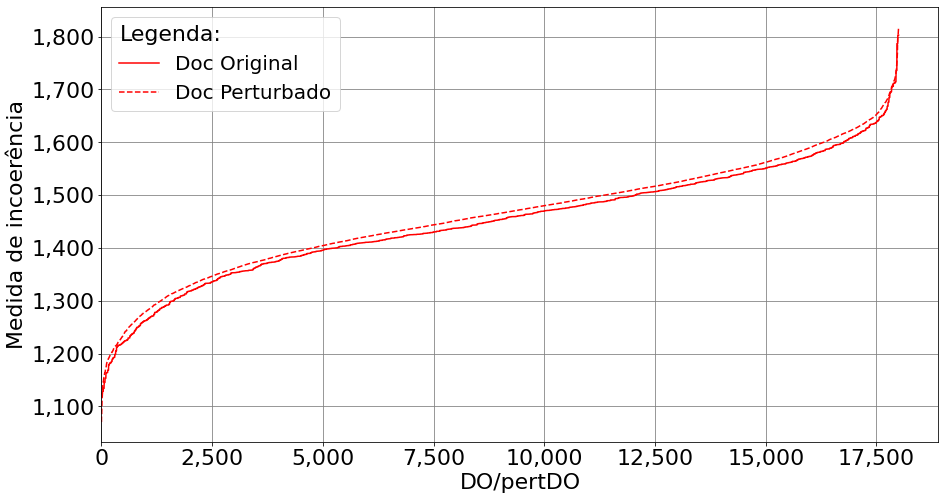

In [296]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

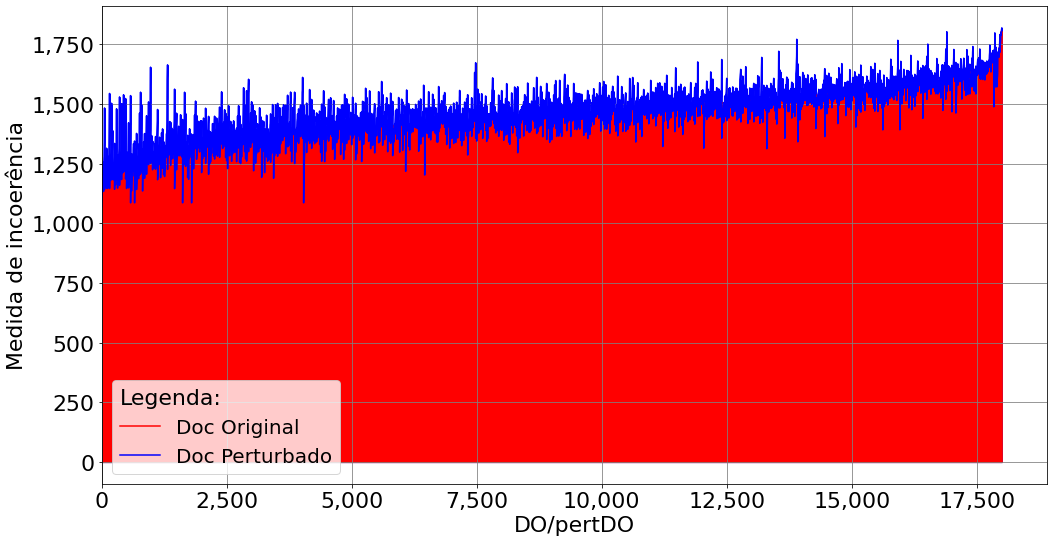

In [297]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [298]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 654370.5883527934

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['a483f5977b9e4492add28bb1b6ec9b85', 114.99045555555608, 897, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['6066b65076d145658e78b885fcf5496e', 133.0499471698106, 900, 'De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?']
['9148d87eb4b34d9390f8a485116361ae', 146.43347500000323, 571, 'Por que 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [299]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 431767.7002891692

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['dd3f5ea3ed4f404ab1359896e2a98513', 0.3347571428569154, 814, 'A quem Zuse tentou vender o Z1?']
['c330f27f8f4d49e2b6cc95fb205cab76', 0.9095666666669331, 533, 'Com o que os computadores eram incompartíveis até 1960?']
['fd743cb55d85462f8981bd51fe92f50e', 1.0223714285716596, 140, 'quais são as atribuições acadêmicas do nde?']
['38087b76b3674f84bb471fdce0103265', 1.0931777777780098, 527, 'onde está definido o prazo para renovação de matrícula?']
['8526510cde3749f4802e483f09ae2411', 1.8120555555551618, 668, 'Como a ciência da computação se classifica enquanto ciência?']

Os 5 últimos DOs
id_

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [300]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [301]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: e1b3afdedeab46bc9dad7e7807935f06
DO: Do que se tratam as atividades complementares?
     ADP PRON PRON VERB DET NOUN ADJ PUNCT 
  1 - Do que se destacam as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> destacam(CAWman(pertDO)=1403,1804857143)] - VERB/VERB-1-0
  2 - Do que se trata as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> trata(CAWman(pertDO)=1456,6349571429)] - VERB/VERB-1-0
  3 - Do que se referem as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> referem(CAWman(pertDO)=1461,3780000000)] - VERB/VERB-1-0
  4 - Do que se serve as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> serve(CAWman(pertDO)=1511,9615000000)] - VERB/VERB-1-0
  5 - Do que se servem as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> servem(CAWman(pertDO)=1521,6724000000)] - VERB/VERB-1-0
  6 - Do que se ocupam as atividades complementares ? [tratam(>CAWman(DO)=1352,5140714286) -> ocupam(CAWman(pertD

In [302]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: e1b3afdedeab46bc9dad7e7807935f06
DO: Do que se tratam as atividades complementares?
     ADP PRON PRON VERB DET NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
e1b3afdedeab46bc9dad7e7807935f06_pert_0;Do que se constituem as atividades complementares ?;tratam;VERB;1352,5140714286;1505,9099321429;1000,5561425000;constituem;VERB;1589,2202142857;1673,8575892857;1105,7873500000;0,4222203791;0;1
e1b3afdedeab46bc9dad7e7807935f06_pert_1;Do que se compõem as atividades complementares ?;tratam;VERB;1352,5140714286;1505,9099321429;1000,5561425000;compõem;VERB;1584,2846000000;1664,6324714286;1098,6811500000;0,2607199848;0;1
e1b3afdedeab46bc9dad7e7807935f06_pert_2;Do que se trata as atividades complementares ?;tratam;VERB;1352,5140714286;1505,9099321429;1000,5561425000;trata;VERB;1456,6349571429;1579,1130964286;1042,3270312500;0,0690004304;0

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [303]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 222602.88806362852

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad7ec48d7b24069bebc0f3848d3b66d', 0.0972214285714017, 601, 'Do que a tomada de decisão no setor público de saúde é extremamente dependente?']
['a522ca722b5046c498e41d97b36fe029', 0.6521666666667443, 377, 'Os estudos da ciência da computação podem ser aplicadas em quais áreas?']
['9d787ca422f2409f90a1d84f7fe1c16c', 1.0259749999997894, 23, 'O que é EDI?']
['39b55469ac19414db4eaf98c9df2fdce', 1.0858857142859506, 241, 'Como os dispositivos da placa-mãe são conectados?']
['5c354067840b4f8aba602f26462c24c9', 1.1251833333330978, 373, 'Ao que os candidatos têm acesso?']

Os 5 últimos DOs
id_D

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [304]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [305]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWman(DO)=1377,5251750000) -> isso(>CAWman(pertDO)=1086,1962000000)] - NOUN/PRON-0-0
  2 - O que é verdade ? [monografia(CAWman(DO)=1377,5251750000) -> verdade(>CAWman(pertDO)=1118,9100000000)] - NOUN/NOUN-1-0
  3 - O que é bom ? [monografia(CAWman(DO)=1377,5251750000) -> bom(>CAWman(pertDO)=1127,3652000000)] - NOUN/ADJ-0-0
  4 - O que é Deus ? [monografia(CAWman(DO)=1377,5251750000) -> Deus(>CAWman(pertDO)=1156,0908250000)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWman(DO)=1377,5251750000) -> isto(>CAWman(pertDO)=1173,0319500000)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWman(DO)=1377,5251750000) -> melhor(>CAWman(pertDO)=1191,3121500000)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWman(DO)=1377,5251750000) -> ciência(>CAWman(pertDO)=1200,5656500000)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWman(DO)=1377,52517500

In [306]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isso;PRON;1086,1962000000;1169,9812900000;742,5140720000;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isto;PRON;1173,0319500000;1236,1990700000;784,2883980000;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;amor;NOUN;1279,9722250000;1311,7562200000;828,3682320000;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;câncer;NOUN;1215,0255750

#### Usando CWP

In [307]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 640539.6611529754

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1be21a9cc55a41a5b3d98a094e4b3fbe', 135.3830978022013, 855, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['ba3433a97a9345b0bd1b93acd868eace', 135.9740992982454, 893, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['d4c1625406744464879a6e1c63192c0b', 139.23373339868772, 533, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['f3a38e6e0cb6480bac4b6661a9558acc', 158.87454502923197, 890, 'Quando o acadêmico em regime de exercícios domiciliares poderá prestar as provas que foram aplicadas durante o afastamento?']
['6ad8ea15044147118087cddcb85

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [308]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 386923.49712517334

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['de77e77219814510ba4379f31dc78cf1', 0.31002952381072646, 741, 'O que o POSCOMP constitui para a seleção de candidatos pelas Instituições de Ensino?']
['98f626a2793b44859d3018dc9d2503d6', 1.9251238095232566, 162, 'Qual o princípio da pesquisa descritiva?']
['ce96bf83cc5d4fe09b8b525b5d94a6ff', 1.980105714285628, 653, 'Por que é importante ressaltar os problemas que a tecnologia traz para as empresas?']
['d0b4d7d5901643719e812aab15d70068', 2.2752761904760064, 121, 'Como os primeiros processadores eram construídos?']
['d35688f40f6941b9b951eb2edf9e0ae2', 2.677713636363478, 740, 'Para que 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [309]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [310]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é IBM ? [é(>CWPman(DO)=1308,6073100000) -> é(CWPman(pertDO)=1308,6073100000)] - AUX/AUX-1-1
  2 - O que a IBM ? [é(>CWPman(DO)=1308,6073100000) -> a(CWPman(pertDO)=1325,2274000000)] - AUX/DET-0-0
  3 - O que era IBM ? [é(>CWPman(DO)=1308,6073100000) -> era(CWPman(pertDO)=1338,5440400000)] - AUX/AUX-1-0
  4 - O que significa IBM ? [é(>CWPman(DO)=1308,6073100000) -> significa(CWPman(pertDO)=1342,9046700000)] - AUX/VERB-0-0
  5 - O que seria IBM ? [é(>CWPman(DO)=1308,6073100000) -> seria(CWPman(pertDO)=1390,3099900000)] - AUX/AUX-1-0
  6 - O que significava IBM ? [é(>CWPman(DO)=1308,6073100000) -> significava(CWPman(pertDO)=1403,4444940000)] - AUX/VERB-0-0
  7 - O que são IBM ? [é(>CWPman(DO)=1308,6073100000) -> são(CWPman(pertDO)=1409,1284800000)] - AUX/AUX-1-0
  8 - O que faz IBM ? [é(>CWPman(DO)=1308,6073100000) -> faz(CWPman(pertDO)=1412,9843000000)] - AUX/VERB-0-0
  9 - O que seja IBM

In [311]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
939e08851c6c469da76d0c58d47e225c_pert_0;O que é IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;0,7576153874;1;1
939e08851c6c469da76d0c58d47e225c_pert_1;O que significa IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;significa;VERB;1308,2526250000;1342,9046700000;850,4783200000;0,0786152855;0;0
939e08851c6c469da76d0c58d47e225c_pert_2;O que era IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;era;AUX;1326,4270500000;1338,5440400000;847,2183000000;0,0348249562;0;1
939e08851c6c469da76d0c58d47e225c_pert_3;O que a IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;a;DET;1292,7033000000;1325,2274000000;838,4789640000;0,0317151062;0

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [312]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 253616.1640277982

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ef5b758fd4fe44a38b538cb37f9abea9', 0.09110663157957788, 631, 'O que deve haver para que um cálculo possa ser realizado por um algoritmo sendo executado em um computador?']
['13d4fe43c9504e05a5923b0ef30b9d18', 0.26325393939328023, 186, 'Qual o prazo de aprovação do plano de ensino das disciplinas?']
['95c7ecf942fb4af28a05eb425e6dbc51', 0.4877514285710731, 838, 'qual a nota mínima para o acadêmico que requisitou abreviação de curso ser aprovado?']
['bb7dc667337b4cf2af309d60a1f1ecb2', 0.6097681318669856, 632, 'como deve ser distribuidas as disciplinas que o acadêmico está apto a cursar?

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [313]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [314]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
  1 - Qual era o plano do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> plano(>CWPman(pertDO)=1214,3319261905)] - NOUN/NOUN-1-0
  2 - Qual era o projeto do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> projeto(>CWPman(pertDO)=1219,9695666667)] - NOUN/NOUN-1-0
  3 - Qual era o discurso do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> discurso(>CWPman(pertDO)=1221,5619142857)] - NOUN/NOUN-1-0
  4 - Qual era o programa do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> programa(>CWPman(pertDO)=1224,4510209524)] - NOUN/NOUN-1-0
  5 - Qual era o planejamento do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> planejamento(>CWPman(pertDO)=1224,9218971429)] - NOUN/NOUN-1-0
  6 - Qual era o critério do MEC ? [precursor(CWPman(DO)=1425,3098476190) -> critério(>CWPman(pertDO)=1238,0359952381)] - NOUN/NOUN-1-0
  7 - Qual era o compromisso do MEC ? [precursor(CWPman(DO)=1425,309847

In [315]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 83e3da1f287e4628b9b96ec37f549407
DO: Qual era o precursor do MEC?
     PRON AUX DET NOUN ADP PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
83e3da1f287e4628b9b96ec37f549407_pert_0;Qual era o papel do MEC ?;precursor;NOUN;1356,2354166667;1425,3098476190;935,4724514286;papel;NOUN;1219,7003666667;1253,6376190476;832,5747900000;0,3289101720;0;1
83e3da1f287e4628b9b96ec37f549407_pert_1;Qual era o objetivo do MEC ?;precursor;NOUN;1356,2354166667;1425,3098476190;935,4724514286;objetivo;NOUN;1215,8019333333;1251,5100209524;829,7363528571;0,1418752521;0;1
83e3da1f287e4628b9b96ec37f549407_pert_2;Qual era o interesse do MEC ?;precursor;NOUN;1356,2354166667;1425,3098476190;935,4724514286;interesse;NOUN;1233,6774166667;1250,0260238095;829,2702085714;0,0540307462;0;1
83e3da1f287e4628b9b96ec37f549407_pert_3;Qual era o projeto do MEC ?;precursor;N

#### Usando CG

In [316]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 420778.1671976788

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1be21a9cc55a41a5b3d98a094e4b3fbe', 84.65402857142863, 846, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['d4c1625406744464879a6e1c63192c0b', 96.59919222222106, 615, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['ba3433a97a9345b0bd1b93acd868eace', 97.57982631579057, 893, 'Qual a segunda melhor universidade de Mato Grosso do Sul segundo a avaliação do Índice Geral de Cursos?']
['f3a38e6e0cb6480bac4b6661a9558acc', 104.37107894737142, 888, 'Quando o acadêmico em regime de exercícios domiciliares poderá prestar as provas que foram aplicadas durante o afastamento?']
['6ad8ea15044147118087cddcb8563d

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [317]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 243438.12558935798

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['073f6a5ebc6e4416999320720d1e4f00', 0.16774500000019543, 530, 'O que o curso de Engenharia da Computação da UFRG visa?']
['7014b49284054f09b93c2bfdeb873f1f', 0.25805294117662925, 870, 'Em que foi transformado a modalidade do curso de Ciência da Computaçao com ênfase em hardware?']
['7d0d7b4112a4413ebee5339414c75a8f', 0.29948222222242293, 393, 'Qual a principal atividade dos professores nos EUA?']
['4d837be563594345b5ccb94612982dd0', 0.38198333333366463, 539, 'Onde o acadêmico pode solicitar aproveitamento dos estudos?']
['dea36858d4594186b3db4e3c76e410f1', 0.41733499999998, 177, 'O cal

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [318]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [319]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é IBM ? [é(>CGman(DO)=828,4981800000) -> é(CGman(pertDO)=828,4981800000)] - AUX/AUX-1-1
  2 - O que a IBM ? [é(>CGman(DO)=828,4981800000) -> a(CGman(pertDO)=838,4789640000)] - AUX/DET-0-0
  3 - O que era IBM ? [é(>CGman(DO)=828,4981800000) -> era(CGman(pertDO)=847,2183000000)] - AUX/AUX-1-0
  4 - O que significa IBM ? [é(>CGman(DO)=828,4981800000) -> significa(CGman(pertDO)=850,4783200000)] - AUX/VERB-0-0
  5 - O que seria IBM ? [é(>CGman(DO)=828,4981800000) -> seria(CGman(pertDO)=878,9801580000)] - AUX/AUX-1-0
  6 - O que significava IBM ? [é(>CGman(DO)=828,4981800000) -> significava(CGman(pertDO)=891,2869380000)] - AUX/VERB-0-0
  7 - O que faz IBM ? [é(>CGman(DO)=828,4981800000) -> faz(CGman(pertDO)=892,1328600000)] - AUX/VERB-0-0
  8 - O que são IBM ? [é(>CGman(DO)=828,4981800000) -> são(CGman(pertDO)=895,3286080000)] - AUX/AUX-1-0
  9 - O que seja IBM ? [é(>CGman(DO)=828,4981800000)

In [320]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 939e08851c6c469da76d0c58d47e225c
DO: O que é IBM?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
939e08851c6c469da76d0c58d47e225c_pert_0;O que é IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;0,7576153874;1;1
939e08851c6c469da76d0c58d47e225c_pert_1;O que significa IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;significa;VERB;1308,2526250000;1342,9046700000;850,4783200000;0,0786152855;0;0
939e08851c6c469da76d0c58d47e225c_pert_2;O que era IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;era;AUX;1326,4270500000;1338,5440400000;847,2183000000;0,0348249562;0;1
939e08851c6c469da76d0c58d47e225c_pert_3;O que a IBM ?;é;AUX;1282,9637250000;1308,6073100000;828,4981800000;a;DET;1292,7033000000;1325,2274000000;838,4789640000;0,0317151062;0

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [321]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['39b55469ac19414db4eaf98c9df2fdce', 0.0482462500000338, 140, 'Como os dispositivos da placa-mãe são conectados?']
['a483f5977b9e4492add28bb1b6ec9b85', 0.09347567567556325, 899, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['4b0569a40aa24c4d9e842d78a922b832', 0.27949799999942115, 744, 'Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a funcionar?']
['c67c6a19a3234e2f8c0bd5fa49a90f32', 0.367

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [322]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [323]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é verdade ? [monografia(CGman(DO)=933,5613340000) -> verdade(>CGman(pertDO)=716,6572020000)] - NOUN/NOUN-1-0
  2 - O que é bom ? [monografia(CGman(DO)=933,5613340000) -> bom(>CGman(pertDO)=725,0024000000)] - NOUN/ADJ-0-0
  3 - O que é isso ? [monografia(CGman(DO)=933,5613340000) -> isso(>CGman(pertDO)=742,5140720000)] - NOUN/PRON-0-0
  4 - O que é Deus ? [monografia(CGman(DO)=933,5613340000) -> Deus(>CGman(pertDO)=756,8727160000)] - NOUN/PROPN-0-0
  5 - O que é melhor ? [monografia(CGman(DO)=933,5613340000) -> melhor(>CGman(pertDO)=782,1403320000)] - NOUN/ADJ-0-0
  6 - O que é isto ? [monografia(CGman(DO)=933,5613340000) -> isto(>CGman(pertDO)=784,2883980000)] - NOUN/PRON-0-0
  7 - O que é ciência ? [monografia(CGman(DO)=933,5613340000) -> ciência(>CGman(pertDO)=787,2725440000)] - NOUN/NOUN-1-0
  8 - O que é cultura ? [monografia(CGman(DO)=933,5613340000) -> cultura(>CGman(pertDO)

In [324]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isso;PRON;1086,1962000000;1169,9812900000;742,5140720000;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isto;PRON;1173,0319500000;1236,1990700000;784,2883980000;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;amor;NOUN;1279,9722250000;1311,7562200000;828,3682320000;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;câncer;NOUN;1215,0255750

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [325]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 177340.04160832395

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6066b65076d145658e78b885fcf5496e', 15.879200000000537, 900, 'De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?']
['d4c1625406744464879a6e1c63192c0b', 18.57389411764666, 598, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['a483f5977b9e4492add28bb1b6ec9b85', 18.787030555555702, 897, 'Em qual semestre o acadêmico deve ser enquadrado no 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [326]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['dd3f5ea3ed4f404ab1359896e2a98513', 0.3347571428569154, 814, 'A quem Zuse tentou vender o Z1?']
['c330f27f8f4d49e2b6cc95fb205cab76', 0.9095666666669331, 533, 'Com o que os computadores eram incompartíveis até 1960?']
['fd743cb55d85462f8981bd51fe92f50e', 1.0223714285716596, 140, 'quais são as atribuições acadêmicas do nde?']
['38087b76b3674f84bb471fdce0103265', 1.0931777777780098, 527, 'onde está definido o prazo para renovação de matrícula?']
['8526510cde3749f4802e483f09ae2411', 1.8120555555551618, 668, 'Como a ciência da computação se classifica enquanto ciência?']

Os 5 últimos DOs
id_DO, difab

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [327]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [328]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWman(DO)=1262,0576500000) -> é(CAWman(pertDO)=1262,0576500000)] - AUX/AUX-1-1
  2 - O que era USP ? [é(>CAWman(DO)=1262,0576500000) -> era(CAWman(pertDO)=1308,5755500000)] - AUX/AUX-1-0
  3 - O que faz USP ? [é(>CAWman(DO)=1262,0576500000) -> faz(CAWman(pertDO)=1310,3058500000)] - AUX/VERB-0-0
  4 - O que a USP ? [é(>CAWman(DO)=1262,0576500000) -> a(CAWman(pertDO)=1312,5811750000)] - AUX/DET-0-0
  5 - O que significa USP ? [é(>CAWman(DO)=1262,0576500000) -> significa(CAWman(pertDO)=1341,4838250000)] - AUX/VERB-0-0
  6 - O que uma USP ? [é(>CAWman(DO)=1262,0576500000) -> uma(CAWman(pertDO)=1348,2074250000)] - AUX/DET-0-0
  7 - O que virou USP ? [é(>CAWman(DO)=1262,0576500000) -> virou(CAWman(pertDO)=1365,0088500000)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWman(DO)=1262,0576500000) -> define(CAWman(pertDO)=1374,1537500000)] - AUX/VERB-0-0
  9 - O que diz USP ? [é(>CAW

In [329]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;era;AUX;1308,5755500000;1340,9642900000;847,4381220000;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;significa;VERB;1341,4838250000;1375,2384400000;868,7174740000;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;foi;AUX;1428,9301750000;1433,8271400000;905,6316400000;0,01729971

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [330]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad7ec48d7b24069bebc0f3848d3b66d', 0.0972214285714017, 601, 'Do que a tomada de decisão no setor público de saúde é extremamente dependente?']
['a522ca722b5046c498e41d97b36fe029', 0.6521666666667443, 377, 'Os estudos da ciência da computação podem ser aplicadas em quais áreas?']
['9d787ca422f2409f90a1d84f7fe1c16c', 1.0259749999997894, 23, 'O que é EDI?']
['39b55469ac19414db4eaf98c9df2fdce', 1.0858857142859506, 241, 'Como os dispositivos da placa-mãe são conectados?']
['5c354067840b4f8aba602f26462c24c9', 1.1251833333330978, 373, 'Ao que os candidatos têm acesso?']

Os 5 últimos DOs
id_DO, difabs,

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [331]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [332]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWman(DO)=1377,5251750000) -> isso(>CAWman(pertDO)=1086,1962000000)] - NOUN/PRON-0-0
  2 - O que é verdade ? [monografia(CAWman(DO)=1377,5251750000) -> verdade(>CAWman(pertDO)=1118,9100000000)] - NOUN/NOUN-1-0
  3 - O que é bom ? [monografia(CAWman(DO)=1377,5251750000) -> bom(>CAWman(pertDO)=1127,3652000000)] - NOUN/ADJ-0-0
  4 - O que é Deus ? [monografia(CAWman(DO)=1377,5251750000) -> Deus(>CAWman(pertDO)=1156,0908250000)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWman(DO)=1377,5251750000) -> isto(>CAWman(pertDO)=1173,0319500000)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWman(DO)=1377,5251750000) -> melhor(>CAWman(pertDO)=1191,3121500000)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWman(DO)=1377,5251750000) -> ciência(>CAWman(pertDO)=1200,5656500000)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWman(DO)=1377,52517500

In [333]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isso;PRON;1086,1962000000;1169,9812900000;742,5140720000;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isto;PRON;1173,0319500000;1236,1990700000;784,2883980000;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;amor;NOUN;1279,9722250000;1311,7562200000;828,3682320000;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;câncer;NOUN;1215,0255750

#### Usando CWP






In [334]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 177340.04160832395

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['6066b65076d145658e78b885fcf5496e', 16.74310551362896, 900, 'De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?']
['d4c1625406744464879a6e1c63192c0b', 17.28934660130699, 533, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['f3a38e6e0cb6480bac4b6661a9558acc', 19.976814035085, 890, 'Quando o acadêmico em regime de exercícios domiciliares 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [335]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['de77e77219814510ba4379f31dc78cf1', 0.31002952381072646, 741, 'O que o POSCOMP constitui para a seleção de candidatos pelas Instituições de Ensino?']
['98f626a2793b44859d3018dc9d2503d6', 1.9251238095232566, 162, 'Qual o princípio da pesquisa descritiva?']
['ce96bf83cc5d4fe09b8b525b5d94a6ff', 1.980105714285628, 653, 'Por que é importante ressaltar os problemas que a tecnologia traz para as empresas?']
['d0b4d7d5901643719e812aab15d70068', 2.2752761904760064, 121, 'Como os primeiros processadores eram construídos?']
['d35688f40f6941b9b951eb2edf9e0ae2', 2.677713636363478, 740, 'Para que a engenharia 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [336]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [337]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWman(DO)=1262,0576500000) -> é(CAWman(pertDO)=1262,0576500000)] - AUX/AUX-1-1
  2 - O que era USP ? [é(>CAWman(DO)=1262,0576500000) -> era(CAWman(pertDO)=1308,5755500000)] - AUX/AUX-1-0
  3 - O que faz USP ? [é(>CAWman(DO)=1262,0576500000) -> faz(CAWman(pertDO)=1310,3058500000)] - AUX/VERB-0-0
  4 - O que a USP ? [é(>CAWman(DO)=1262,0576500000) -> a(CAWman(pertDO)=1312,5811750000)] - AUX/DET-0-0
  5 - O que significa USP ? [é(>CAWman(DO)=1262,0576500000) -> significa(CAWman(pertDO)=1341,4838250000)] - AUX/VERB-0-0
  6 - O que uma USP ? [é(>CAWman(DO)=1262,0576500000) -> uma(CAWman(pertDO)=1348,2074250000)] - AUX/DET-0-0
  7 - O que virou USP ? [é(>CAWman(DO)=1262,0576500000) -> virou(CAWman(pertDO)=1365,0088500000)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWman(DO)=1262,0576500000) -> define(CAWman(pertDO)=1374,1537500000)] - AUX/VERB-0-0
  9 - O que diz USP ? [é(>CAW

In [338]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;era;AUX;1308,5755500000;1340,9642900000;847,4381220000;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;significa;VERB;1341,4838250000;1375,2384400000;868,7174740000;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;foi;AUX;1428,9301750000;1433,8271400000;905,6316400000;0,01729971

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [339]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['ef5b758fd4fe44a38b538cb37f9abea9', 0.09110663157957788, 631, 'O que deve haver para que um cálculo possa ser realizado por um algoritmo sendo executado em um computador?']
['13d4fe43c9504e05a5923b0ef30b9d18', 0.26325393939328023, 186, 'Qual o prazo de aprovação do plano de ensino das disciplinas?']
['95c7ecf942fb4af28a05eb425e6dbc51', 0.4877514285710731, 838, 'qual a nota mínima para o acadêmico que requisitou abreviação de curso ser aprovado?']
['bb7dc667337b4cf2af309d60a1f1ecb2', 0.5213780219776254, 632, 'como deve ser distribuidas as disciplinas que o acadêmico está apto a cursar?']
['1c25ffd

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [340]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [341]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWman(DO)=1377,5251750000) -> isso(>CAWman(pertDO)=1086,1962000000)] - NOUN/PRON-0-0
  2 - O que é verdade ? [monografia(CAWman(DO)=1377,5251750000) -> verdade(>CAWman(pertDO)=1118,9100000000)] - NOUN/NOUN-1-0
  3 - O que é bom ? [monografia(CAWman(DO)=1377,5251750000) -> bom(>CAWman(pertDO)=1127,3652000000)] - NOUN/ADJ-0-0
  4 - O que é Deus ? [monografia(CAWman(DO)=1377,5251750000) -> Deus(>CAWman(pertDO)=1156,0908250000)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWman(DO)=1377,5251750000) -> isto(>CAWman(pertDO)=1173,0319500000)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWman(DO)=1377,5251750000) -> melhor(>CAWman(pertDO)=1191,3121500000)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWman(DO)=1377,5251750000) -> ciência(>CAWman(pertDO)=1200,5656500000)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWman(DO)=1377,52517500

In [342]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isso;PRON;1086,1962000000;1169,9812900000;742,5140720000;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isto;PRON;1173,0319500000;1236,1990700000;784,2883980000;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;amor;NOUN;1279,9722250000;1311,7562200000;828,3682320000;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;câncer;NOUN;1215,0255750

#### Usando CG






In [343]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 177340.04160832395

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['d4c1625406744464879a6e1c63192c0b', 10.57330666666644, 615, 'Do que os matemáticos precisavam para descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?']
['1be21a9cc55a41a5b3d98a094e4b3fbe', 11.174657142857086, 846, 'Por que países mais avançados em ciência hoje colem bons frutos nessa área?']
['6066b65076d145658e78b885fcf5496e', 11.786698148147934, 900, 'De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os mo

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [344]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['073f6a5ebc6e4416999320720d1e4f00', 0.16774500000019543, 530, 'O que o curso de Engenharia da Computação da UFRG visa?']
['7014b49284054f09b93c2bfdeb873f1f', 0.1846176470589853, 870, 'Em que foi transformado a modalidade do curso de Ciência da Computaçao com ênfase em hardware?']
['7d0d7b4112a4413ebee5339414c75a8f', 0.29948222222242293, 393, 'Qual a principal atividade dos professores nos EUA?']
['4d837be563594345b5ccb94612982dd0', 0.38198333333366463, 539, 'Onde o acadêmico pode solicitar aproveitamento dos estudos?']
['dea36858d4594186b3db4e3c76e410f1', 0.4009937499999978, 177, 'O calendário acad

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [345]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [346]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
  1 - O que é USP ? [é(>CAWman(DO)=1262,0576500000) -> é(CAWman(pertDO)=1262,0576500000)] - AUX/AUX-1-1
  2 - O que era USP ? [é(>CAWman(DO)=1262,0576500000) -> era(CAWman(pertDO)=1308,5755500000)] - AUX/AUX-1-0
  3 - O que faz USP ? [é(>CAWman(DO)=1262,0576500000) -> faz(CAWman(pertDO)=1310,3058500000)] - AUX/VERB-0-0
  4 - O que a USP ? [é(>CAWman(DO)=1262,0576500000) -> a(CAWman(pertDO)=1312,5811750000)] - AUX/DET-0-0
  5 - O que significa USP ? [é(>CAWman(DO)=1262,0576500000) -> significa(CAWman(pertDO)=1341,4838250000)] - AUX/VERB-0-0
  6 - O que uma USP ? [é(>CAWman(DO)=1262,0576500000) -> uma(CAWman(pertDO)=1348,2074250000)] - AUX/DET-0-0
  7 - O que virou USP ? [é(>CAWman(DO)=1262,0576500000) -> virou(CAWman(pertDO)=1365,0088500000)] - AUX/VERB-0-0
  8 - O que define USP ? [é(>CAWman(DO)=1262,0576500000) -> define(CAWman(pertDO)=1374,1537500000)] - AUX/VERB-0-0
  9 - O que diz USP ? [é(>CAW

In [347]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3aa1c995b3ab491395042fee99790236
DO: O que é USP?
     PRON PRON AUX PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
3aa1c995b3ab491395042fee99790236_pert_0;O que é USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;0,8705152869;1;1
3aa1c995b3ab491395042fee99790236_pert_1;O que era USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;era;AUX;1308,5755500000;1340,9642900000;847,4381220000;0,0398698226;0;1
3aa1c995b3ab491395042fee99790236_pert_2;O que significa USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;significa;VERB;1341,4838250000;1375,2384400000;868,7174740000;0,0276352521;0;0
3aa1c995b3ab491395042fee99790236_pert_3;O que foi USP ?;é;AUX;1262,0576500000;1307,7974700000;827,1924600000;foi;AUX;1428,9301750000;1433,8271400000;905,6316400000;0,01729971

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [348]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 177340.04160832395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['39b55469ac19414db4eaf98c9df2fdce', 0.0482462500000338, 140, 'Como os dispositivos da placa-mãe são conectados?']
['a483f5977b9e4492add28bb1b6ec9b85', 0.09347567567556325, 899, 'Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?']
['4b0569a40aa24c4d9e842d78a922b832', 0.27949799999942115, 744, 'Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a funcionar?']
['c67c6a19a3234e2f8c0bd5fa49a90f32', 0.3672380000000430

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [349]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [350]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
  1 - O que é isso ? [monografia(CAWman(DO)=1377,5251750000) -> isso(>CAWman(pertDO)=1086,1962000000)] - NOUN/PRON-0-0
  2 - O que é verdade ? [monografia(CAWman(DO)=1377,5251750000) -> verdade(>CAWman(pertDO)=1118,9100000000)] - NOUN/NOUN-1-0
  3 - O que é bom ? [monografia(CAWman(DO)=1377,5251750000) -> bom(>CAWman(pertDO)=1127,3652000000)] - NOUN/ADJ-0-0
  4 - O que é Deus ? [monografia(CAWman(DO)=1377,5251750000) -> Deus(>CAWman(pertDO)=1156,0908250000)] - NOUN/PROPN-0-0
  5 - O que é isto ? [monografia(CAWman(DO)=1377,5251750000) -> isto(>CAWman(pertDO)=1173,0319500000)] - NOUN/PRON-0-0
  6 - O que é melhor ? [monografia(CAWman(DO)=1377,5251750000) -> melhor(>CAWman(pertDO)=1191,3121500000)] - NOUN/ADJ-0-0
  7 - O que é ciência ? [monografia(CAWman(DO)=1377,5251750000) -> ciência(>CAWman(pertDO)=1200,5656500000)] - NOUN/NOUN-1-0
  8 - O que é música ? [monografia(CAWman(DO)=1377,52517500

In [351]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: ad0858f4e0164263a5d7fa6ccb677161
DO: O que é monografia?
     PRON PRON AUX NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
ad0858f4e0164263a5d7fa6ccb677161_pert_0;O que é isso ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isso;PRON;1086,1962000000;1169,9812900000;742,5140720000;0,1955924034;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_1;O que é isto ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;isto;PRON;1173,0319500000;1236,1990700000;784,2883980000;0,0303460639;0;0
ad0858f4e0164263a5d7fa6ccb677161_pert_2;O que é amor ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;amor;NOUN;1279,9722250000;1311,7562200000;828,3682320000;0,0162491053;0;1
ad0858f4e0164263a5d7fa6ccb677161_pert_3;O que é câncer ?;monografia;NOUN;1377,5251750000;1421,8869300000;933,5613340000;câncer;NOUN;1215,0255750

# 4 Finalização

## 4.1 Tempo final de processamento



In [352]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:05:21 (h:mm:ss)
